# AI-Driven Workforce Analytics: Employee Attrition Prediction with Workload Insights

## Final Year Project - Data Analytics Pipeline

**Project Overview:**  
This project explores workload as a measurable factor enriching traditional attrition prediction models. By linking workload-related attributes (hours worked, travel frequency, role tenure) with conventional HR predictors (salary, performance, satisfaction), we build a nuanced framework highlighting both attrition risk and workload imbalance.

**Pipeline Phases:**
1. Data Ingestion & Understanding
2. Data Cleaning & Preprocessing
3. Exploratory Data Analysis (EDA)
4. Handling Data Imbalance
5. Feature Engineering & Selection
6. Data Transformation
7. Data Partition

**Output:** Analysis-ready dataset for downstream machine learning modeling.

<h2>Setup Configuration</h2>
<h3>DO NOT Run this locally</h3>

In [ ]:
# Import sys first
import sys

# Always install into the active kernel's environment
%pip install pandas numpy matplotlib seaborn shap joblib imbalanced-learn boto3 s3fs

# Import required libraries
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import shap
import joblib
#import imbalanced_learn
import inspect
import os
import sys
import boto3
from io import StringIO, BytesIO
from IPython.display import display, HTML
#from sklearn.model_selection import train_test_split
#from sklearn.impute import SimpleImputer
#from sklearn.preprocessing import StandardScaler, MinMaxScaler
#from sklearn.linear_model import LogisticRegression
#from sklearn.tree import DecisionTreeClassifier
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import ( roc_auc_score, precision_score, recall_score, f1_score, brier_score_loss)
#from sklearn.cluster import KMeans

# Import custom modules
from modules import (
    data_cleaning, data_explore, data_ingestion, data_partition, data_transformation, 
    eda, feature_engineering, imbalance_handling, init, post_transformation_eda
)

# Configuration
warnings.filterwarnings("ignore")
pd.set_option('display.max.columns', None)
pd.set_option('display.width', 1000)
np.random.seed(42)

# Create output directories
os.makedirs('outputs', exist_ok=True)
os.makedirs('data', exist_ok=True)

print("Environment configured successfully")
print("Output directories created: 'outputs/', 'data/'")

# Auto-reload modules on change
%load_ext autoreload
%autoreload 2

'{sys.executable}' is not recognized as an internal or external command,
operable program or batch file.
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'boto3'

In [12]:
from modules.data_ingestion import inspect_data

#bucket_name = 'fypemployeeattrition'
#file_key = 'Extended_Employee_Performance_and_Productivity_Data_realistic_highpattern.csv'

# Get the object
#obj = s3.get_object(Bucket=bucket_name, Key=file_key)

# Read into pandas DataFrame
#data = obj['Body'].read().decode('utf-8')
#df_raw = pd.read_csv(StringIO(data))

#df_raw.info()
#info_df = inspect_data(df_raw)

# Local dataset ingestion (AWS S3 reserved for future use)

local_file = "Extended_Employee_Performance_and_Productivity_Data_realistic_highpattern (1).csv"

df_raw = pd.read_csv(local_file)

df_raw.info()
info_df = inspect_data(df_raw)

from modules import (
    data_cleaning, data_explore, data_ingestion, data_partition, data_transformation, 
    eda, feature_engineering, imbalance_handling, post_transformation_eda
)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Employee_ID                  100000 non-null  int64  
 1   Department                   100000 non-null  object 
 2   Gender                       100000 non-null  object 
 3   Age                          100000 non-null  int64  
 4   Job_Title                    100000 non-null  object 
 5   Hire_Date                    100000 non-null  object 
 6   Years_At_Company             100000 non-null  int64  
 7   Education_Level              100000 non-null  object 
 8   Performance_Score            100000 non-null  float64
 9   Monthly_Salary               100000 non-null  float64
 10  Work_Hours_Per_Week          100000 non-null  float64
 11  Projects_Handled             100000 non-null  int64  
 12  Overtime_Hours               100000 non-null  float64
 13  

Column,Type,Non-Null,Null,Null%,Unique
Employee_ID,int64,100000,0,0.00,100000
Department,object,100000,0,0.00,9
Gender,object,100000,0,0.00,3
Age,int64,100000,0,0.00,43
Job_Title,object,100000,0,0.00,7
Hire_Date,object,100000,0,0.00,3463
Years_At_Company,int64,100000,0,0.00,11
Education_Level,object,100000,0,0.00,4
Performance_Score,float64,100000,0,0.00,400
Monthly_Salary,float64,100000,0,0.00,90936


Resigned,Count,Percentage
False,89990,89.99
True,10010,10.01


Feature,count,mean,std,min,25%,50%,75%,max
Employee_ID,100000.0,50000.50,28867.66,1.0,25000.75,50000.50,75000.25,100000.00
Age,100000.0,41.12,11.12,20.0,31.00,41.00,51.00,62.00
Years_At_Company,100000.0,4.48,2.87,0.0,2.00,4.00,7.00,10.00
Performance_Score,100000.0,3.64,0.64,1.0,3.23,3.66,4.08,5.00
Monthly_Salary,100000.0,6654.73,3316.94,300.0,5235.43,6097.10,7259.12,98202.96
Work_Hours_Per_Week,100000.0,36.89,4.18,20.0,34.10,36.80,39.70,55.50
Projects_Handled,100000.0,3.20,1.84,0.0,2.00,3.00,4.00,14.00
Overtime_Hours,100000.0,1.57,5.85,0.0,0.30,0.70,1.50,156.40
Sick_Days,100000.0,3.05,1.75,0.0,2.00,3.00,4.00,13.00
Team_Size,100000.0,7.00,2.45,1.0,5.00,7.00,9.00,19.00


Count,count
Marketing,11216
Finance,11200
Operations,11181
IT,11131
Sales,11122
Legal,11118
Customer Support,11116
HR,10960
Engineering,10956


Count,count
Male,48031
Female,48001
Other,3968


Count,count
Specialist,14507
Manager,14325
Technician,14285
Analyst,14261
Engineer,14217
Consultant,14210
Developer,14195


Count,count
2025-10-29,5108
2024-06-15,46
2024-04-07,46
2023-08-16,46
2023-06-27,45
2016-09-20,45
2019-06-06,45
2018-12-22,44
2022-07-10,44
2017-10-18,43


Count,count
Bachelor,50041
High School,30004
Master,14904
PhD,5051


Count,count
Sometimes,39918
Often,19989
Rarely,18001
Never,12075
Always,10017


Count,count
False,89990
True,10010


In [13]:
pd.set_option('display.max_columns', None)
df_raw.head(10)

,Employee_ID,Department,Gender,Age,Job_Title,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
0,1,IT,Male,55,Specialist,2023-10-07,2,High School,3.69,4523.03,39.8,4,144.0,1,Sometimes,8,28.2,1,7.04,False
1,2,Finance,Male,29,Developer,2025-05-24,0,High School,3.38,7290.79,37.9,2,0.6,3,Always,4,NaN,0,7.99,False
2,3,Finance,Male,55,Specialist,2017-07-30,8,High School,3.76,8114.38,36.9,2,0.3,3,Sometimes,7,17.4,2,8.17,False
3,4,Customer Support,Female,48,Analyst,2018-12-12,7,Bachelor,4.41,5952.56,37.0,2,1.1,5,Often,4,24.4,2,5.51,False
4,5,Engineering,Female,36,Analyst,2022-11-14,3,Bachelor,4.17,5093.78,46.3,5,3.8,2,Rarely,3,17.5,1,9.78,False
5,6,IT,Male,43,Manager,2017-06-13,8,High School,5.00,9092.83,39.8,1,0.1,2,Often,6,10.8,3,6.09,False
6,7,IT,Male,37,Technician,2025-04-02,1,Bachelor,4.70,4950.98,25.9,2,0.7,0,Often,9,15.2,0,9.68,False
7,8,Engineering,Female,55,Engineer,2016-10-31,9,Bachelor,2.90,5307.64,41.1,5,1.2,1,Rarely,8,26.5,3,6.83,False
8,9,Marketing,Female,55,Technician,2024-10-26,1,High School,3.35,4819.08,41.8,1,1.1,3,Sometimes,10,13.9,0,5.96,False
9,10,Engineering,Female,45,Consultant,2018-06-13,7,Bachelor,3.32,5923.40,44.3,2,4.0,2,Rarely,9,21.2,2,7.48,False


<h2>2.0 Initial Data Exploration</h2>

 Running EDA (mode='all')



==============================  SUMMARY FUNCTIONS  ==============================


→ basic_info
----------------------------------------------------------------------
Basic Data Information
Shape: (50, 20)

Data Types:
Employee_ID                      int64
Department                      object
Gender                          object
Age                              int64
Job_Title                       object
Hire_Date                       object
Years_At_Company                 int64
Education_Level                 object
Performance_Score              float64
Monthly_Salary                 float64
Work_Hours_Per_Week            float64
Projects_Handled                 int64
Overtime_Hours                 float64
Sick_Days                        int64
Remote_Work_Frequency           object
Team_Size                        int64
Training_Hours                 float64
Promotions                       int64
Employee_Satisfaction_Score    float64
Resigned  

,Missing Count,Percent
Training_Hours,5,10.0





→ numerical_summary
----------------------------------------------------------------------


,Employee_ID,Age,Years_At_Company,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score
count,50.00000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,45.000000,50.000000,50.000000
mean,25.50000,41.980000,4.280000,3.743400,6524.248200,37.020000,3.380000,4.014000,2.540000,7.240000,18.417778,1.320000,7.303000
std,14.57738,11.316396,3.110483,0.664062,2002.164295,4.585336,1.748352,20.226059,1.528104,2.653915,6.991108,1.077412,1.253928
min,1.00000,24.000000,0.000000,2.420000,4113.380000,22.800000,1.000000,0.000000,0.000000,3.000000,4.400000,0.000000,3.670000
25%,13.25000,29.500000,1.250000,3.325000,5030.990000,33.950000,2.000000,0.425000,1.250000,5.000000,13.900000,0.000000,6.337500
50%,25.50000,43.000000,3.500000,3.605000,5928.725000,37.250000,3.000000,1.000000,2.000000,7.000000,19.000000,1.000000,7.560000
75%,37.75000,52.000000,7.750000,4.385000,7484.427500,40.500000,4.750000,1.475000,4.000000,8.750000,24.400000,2.000000,8.192500
max,50.00000,60.000000,9.000000,5.000000,13856.510000,46.300000,7.000000,144.000000,6.000000,17.000000,30.000000,4.000000,9.780000






==============================  VISUALIZATION FUNCTIONS  ==============================


→ correlation_heatmap
----------------------------------------------------------------------


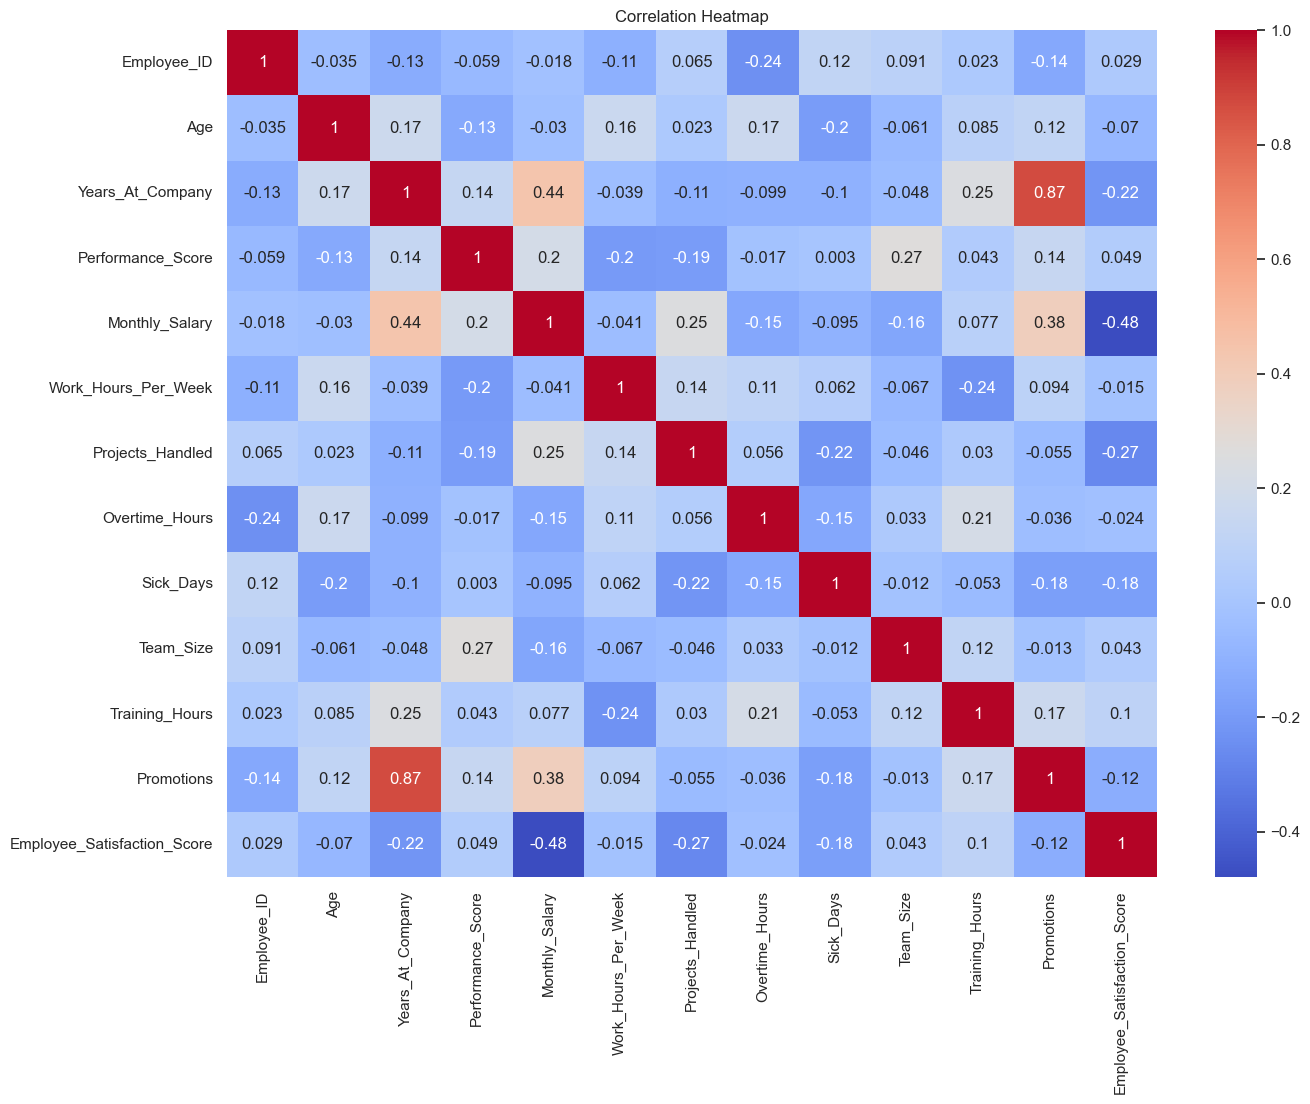




→ detect_outliers
----------------------------------------------------------------------
Employee_ID: 0 outliers
Age: 0 outliers
Years_At_Company: 0 outliers
Performance_Score: 0 outliers
Monthly_Salary: 1 outliers
Work_Hours_Per_Week: 1 outliers
Projects_Handled: 0 outliers
Overtime_Hours: 5 outliers
Sick_Days: 0 outliers
Team_Size: 1 outliers
Training_Hours: 0 outliers
Promotions: 0 outliers
Employee_Satisfaction_Score: 0 outliers


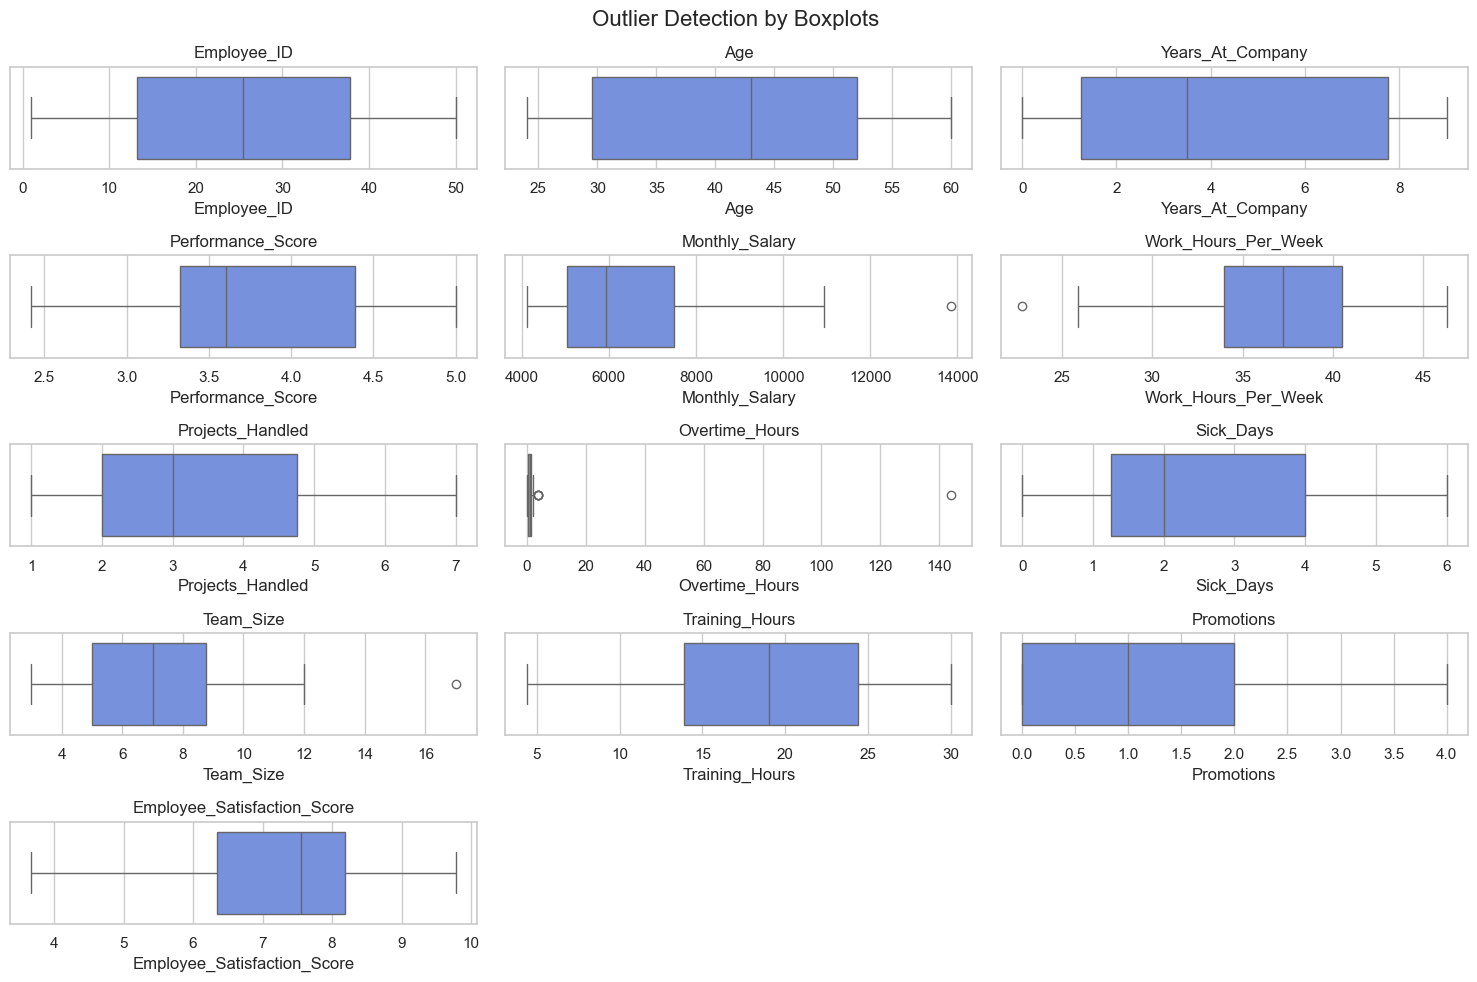




→ plot_categorical
----------------------------------------------------------------------


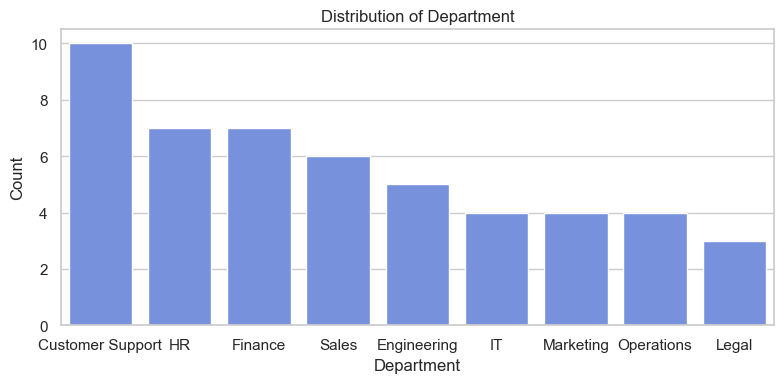

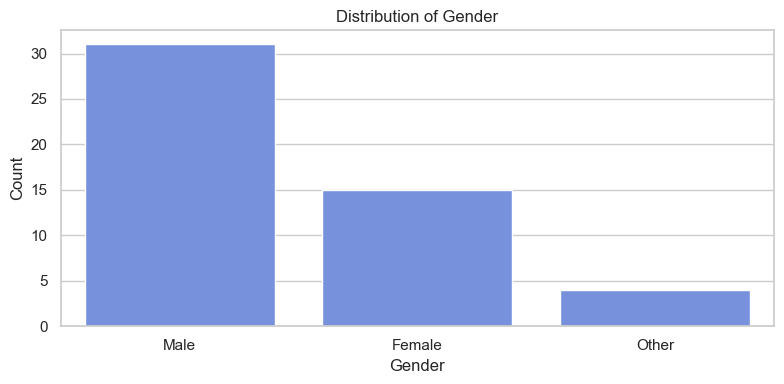

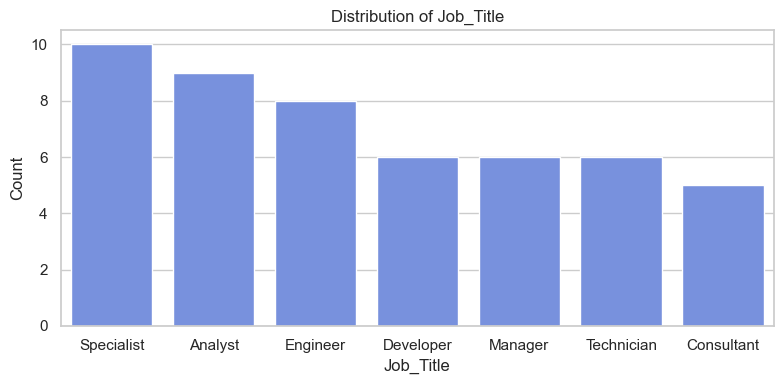

2026-02-03 17:03:02,503 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-03 17:03:02,515 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


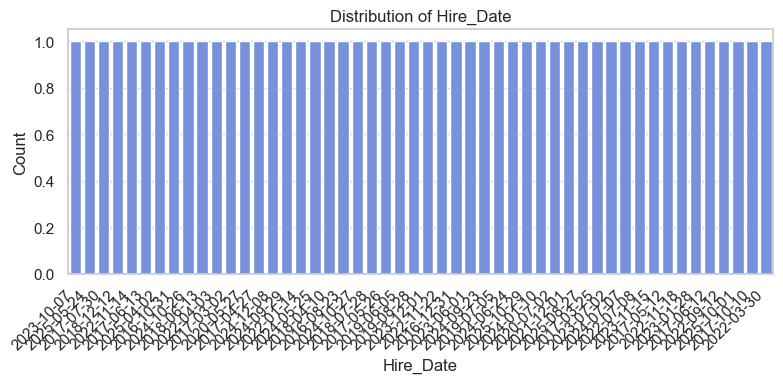

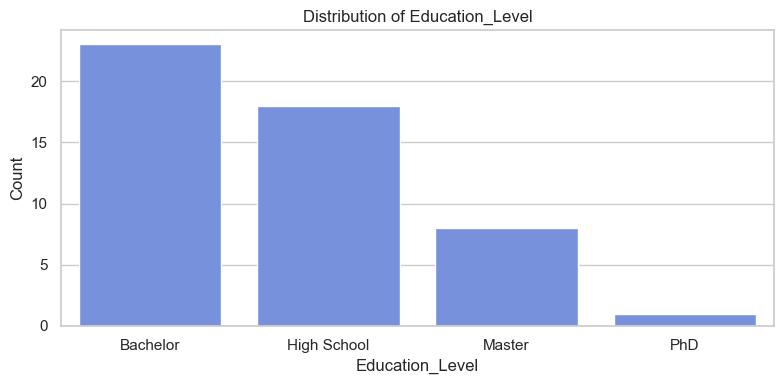

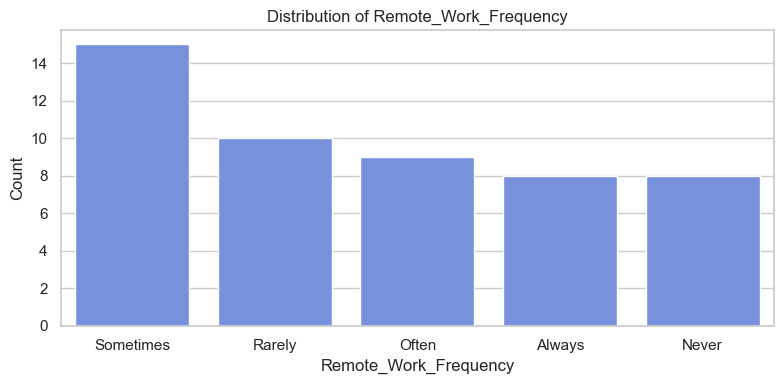

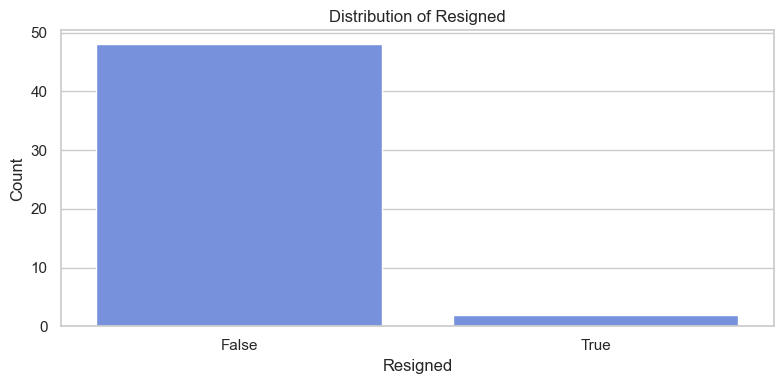




→ plot_numerical
----------------------------------------------------------------------


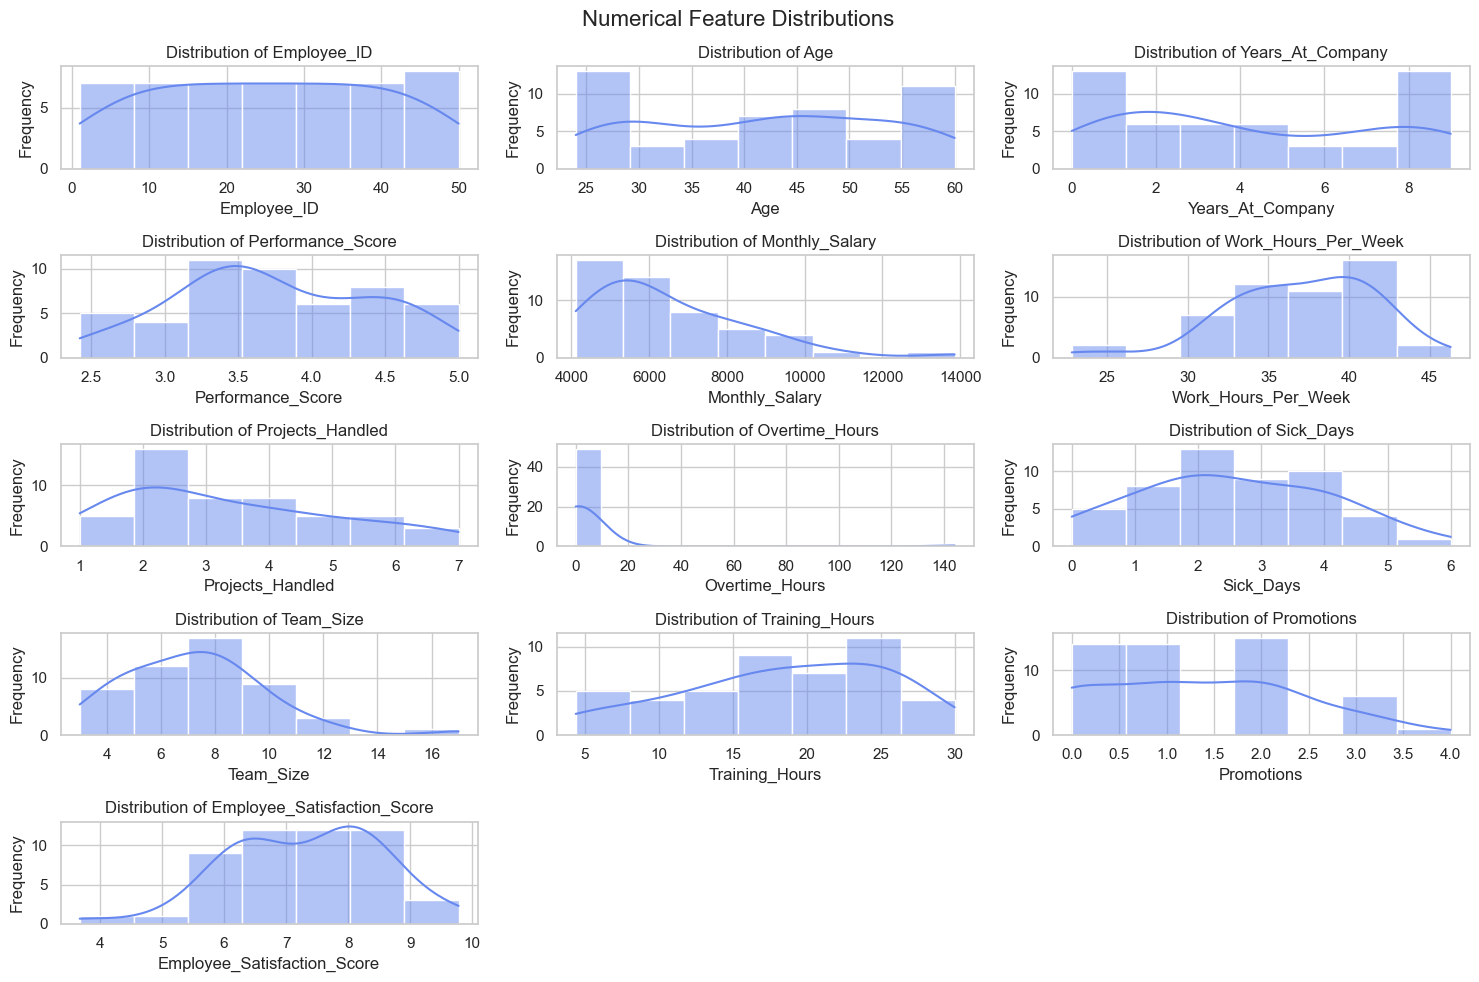




 EDA Completed!


In [14]:
from modules import data_explore

# Run summaries only (fast)
#data_explore.run_eda(df_raw, mode="summary")

# Run visualizations only
#data_explore.run_eda(df_raw, mode="visual")

# Or run full EDA
data_explore.run_eda(df_raw, mode="all")

<h2>3.0 Data Cleaning & Preprocessing</h2>

**Key Activities:**
- Handle missing values: Training_Hours (imputation strategy)
- Remove duplicate records
- Convert data types (dates, booleans, numerics)
- Detect outliers using IQR and Z-score methods

In [15]:
# clean data
df_clean, outlier_info = data_cleaning.clean_data(df_raw.copy())

# Save cleaned data into another csv file
df_clean.to_csv('data/cleaned_data.csv', index=False)
print("\n✓ Cleaned data saved to: data/cleaned_data.csv")

2026-02-03 17:03:16,356 | INFO | ================================================================================
2026-02-03 17:03:16,357 | INFO | STARTING DATA CLEANING PIPELINE
2026-02-03 17:03:16,358 | INFO | ================================================================================
2026-02-03 17:03:16,359 | INFO | ================================================================================
2026-02-03 17:03:16,359 | INFO | MISSING VALUE ANALYSIS
2026-02-03 17:03:16,360 | INFO | ================================================================================
2026-02-03 17:03:16,403 | INFO | 
Columns with missing values:
                Missing  Percentage
Training_Hours     4986        4.99
c:\Users\User\FYP System Development\modules\data_cleaning.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the inte


✓ Cleaned data saved to: data/cleaned_data.csv


In [16]:
df_clean

,Employee_ID,Department,Gender,Age,Job_Title,Hire_Date,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
0,1,IT,Male,55,Specialist,2023-10-07,2,High School,3.69,4523.03,39.8,4,144.0,1,Sometimes,8,28.2,1,7.04,0
1,2,Finance,Male,29,Developer,2025-05-24,0,High School,3.38,7290.79,37.9,2,0.6,3,Always,4,19.2,0,7.99,0
2,3,Finance,Male,55,Specialist,2017-07-30,8,High School,3.76,8114.38,36.9,2,0.3,3,Sometimes,7,17.4,2,8.17,0
3,4,Customer Support,Female,48,Analyst,2018-12-12,7,Bachelor,4.41,5952.56,37.0,2,1.1,5,Often,4,24.4,2,5.51,0
4,5,Engineering,Female,36,Analyst,2022-11-14,3,Bachelor,4.17,5093.78,46.3,5,3.8,2,Rarely,3,17.5,1,9.78,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,99996,Finance,Male,27,Technician,2025-04-16,1,Bachelor,3.72,6232.82,41.7,2,1.2,2,Always,7,18.2,0,8.03,0
99996,99997,IT,Female,36,Consultant,2019-11-13,6,Master,2.91,6023.42,36.7,3,0.1,1,Sometimes,8,7.8,2,5.90,1
99997,99998,Operations,Male,53,Analyst,2017-08-23,8,High School,3.48,5875.00,26.1,1,3.2,2,Often,7,20.6,3,8.39,0
99998,99999,HR,Female,27,Consultant,2017-02-19,9,High School,3.20,5199.21,33.1,3,0.0,2,Never,12,21.6,3,5.59,0


## Phase 3: Exploratory Data Analysis (EDA)

**Objective:** Uncover patterns, distributions, and relationships between workload features and attrition.

**Key Activities:**
- Analyze target variable distribution (attrition rate)
- Explore workload features (hours, overtime, projects, sick days)
- Correlation analysis with attrition
- Categorical feature analysis (department, gender, education)
- Satisfaction and performance patterns
- Workload intensity deep dive

**Possible Enhancements:**
- auto-generated EDA summary report that aggregates key findings such as attrition rate, top correlated features, and chi-square results
- Upload the report into S3 bucket

2026-02-03 17:04:24,782 | INFO | ================================================================================
2026-02-03 17:04:24,783 | INFO | 🚀 STARTING EXPLORATORY DATA ANALYSIS (INITIAL PHASE)
2026-02-03 17:04:24,784 | INFO | ================================================================================
2026-02-03 17:04:24,785 | INFO | === TARGET VARIABLE ANALYSIS: ATTRITION ===
c:\Users\User\FYP System Development\modules\eda.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.99:1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  summary_df.loc["Imbalance Ratio", ["Count", "Percentage (%)"]] = [f"{ratio:.2f}:1", ""]
c:\Users\User\FYP System Development\modules\eda.py:85: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explic

,Count,Percentage (%)
Resigned,,
0,89990.000000,89.990000
1,10010.000000,10.010000
Imbalance Ratio,8.99:1,


2026-02-03 17:04:24,923 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
c:\Users\User\FYP System Development\modules\eda.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="Resigned", ax=axes[0], palette=PLOT_CONFIG["palette_resigned"])
2026-02-03 17:04:25,028 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
c:\Users\User\FYP System Development\modules\eda.py:95: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(["Not Resigne

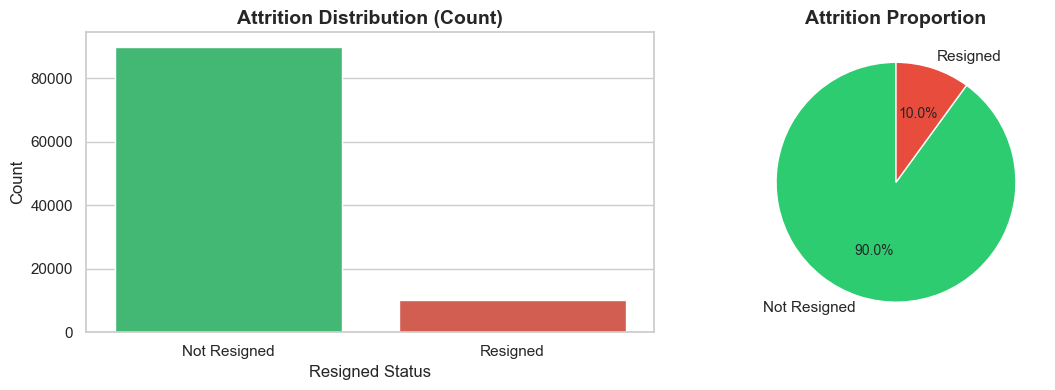

2026-02-03 17:04:25,661 | INFO | === WORKLOAD FEATURES ANALYSIS ===


2026-02-03 17:04:25,879 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
c:\Users\User\FYP System Development\modules\eda.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Resigned", y=col, ax=axes[idx],
2026-02-03 17:04:25,987 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
c:\Users\User\FYP System Development\modules\eda.py:136: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[idx].set_xticklabels(["Not Resigned", "Resigned"])
2026-02-03 17

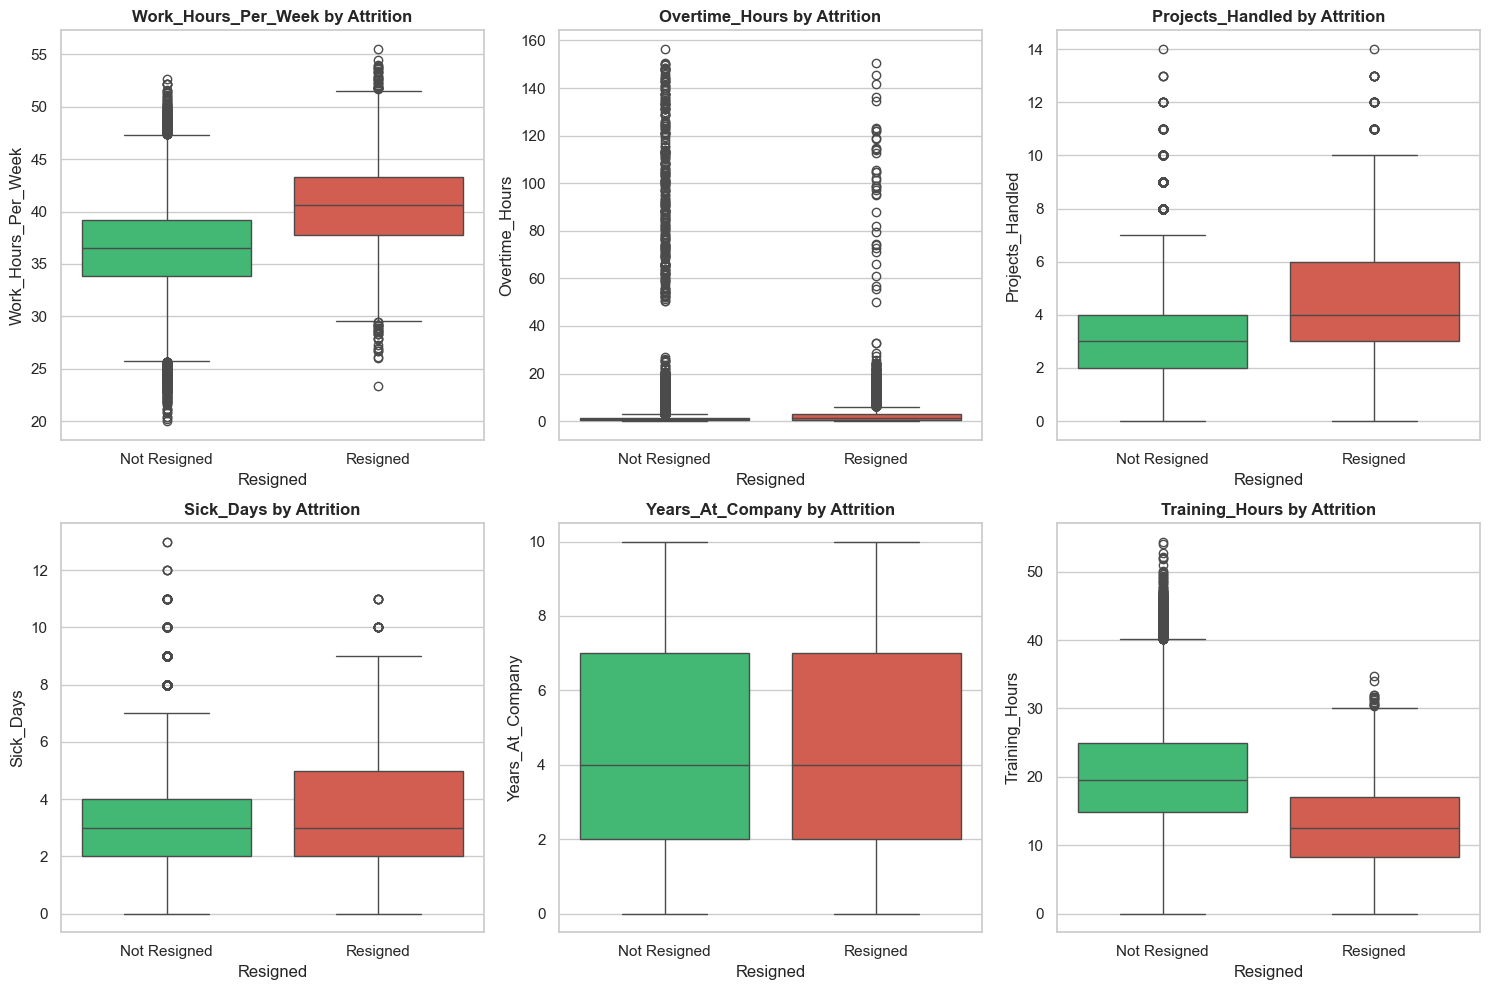

2026-02-03 17:04:29,833 | INFO | === CORRELATION ANALYSIS ===


,Age,Years_At_Company,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned
Age,1.000000,0.010000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.010000,0.010000,-0.000000,0.000000
Years_At_Company,0.010000,1.000000,-0.010000,0.150000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.850000,0.000000,0.000000
Performance_Score,0.000000,-0.010000,1.000000,-0.000000,-0.080000,-0.050000,-0.020000,-0.020000,0.000000,0.080000,0.030000,0.170000,-0.280000
Monthly_Salary,0.000000,0.150000,-0.000000,1.000000,-0.000000,0.040000,0.000000,0.000000,0.000000,0.000000,0.130000,-0.000000,0.000000
Work_Hours_Per_Week,-0.000000,0.000000,-0.080000,-0.000000,1.000000,0.060000,0.120000,0.020000,0.000000,-0.090000,-0.040000,-0.180000,0.290000
Projects_Handled,0.000000,0.000000,-0.050000,0.040000,0.060000,1.000000,0.010000,0.020000,0.000000,-0.060000,-0.030000,-0.130000,0.200000
Overtime_Hours,0.000000,0.000000,-0.020000,0.000000,0.120000,0.010000,1.000000,0.010000,0.000000,-0.020000,-0.000000,-0.030000,0.060000
Sick_Days,0.000000,-0.000000,-0.020000,0.000000,0.020000,0.020000,0.010000,1.000000,0.000000,-0.020000,-0.010000,-0.040000,0.070000
Team_Size,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,-0.000000
Training_Hours,-0.010000,-0.000000,0.080000,0.000000,-0.090000,-0.060000,-0.020000,-0.020000,-0.000000,1.000000,0.040000,0.170000,-0.280000


2026-02-03 17:04:31,268 | INFO | ✅ Saved Full Correlation Matrix: outputs/03a_full_correlation_matrix.png


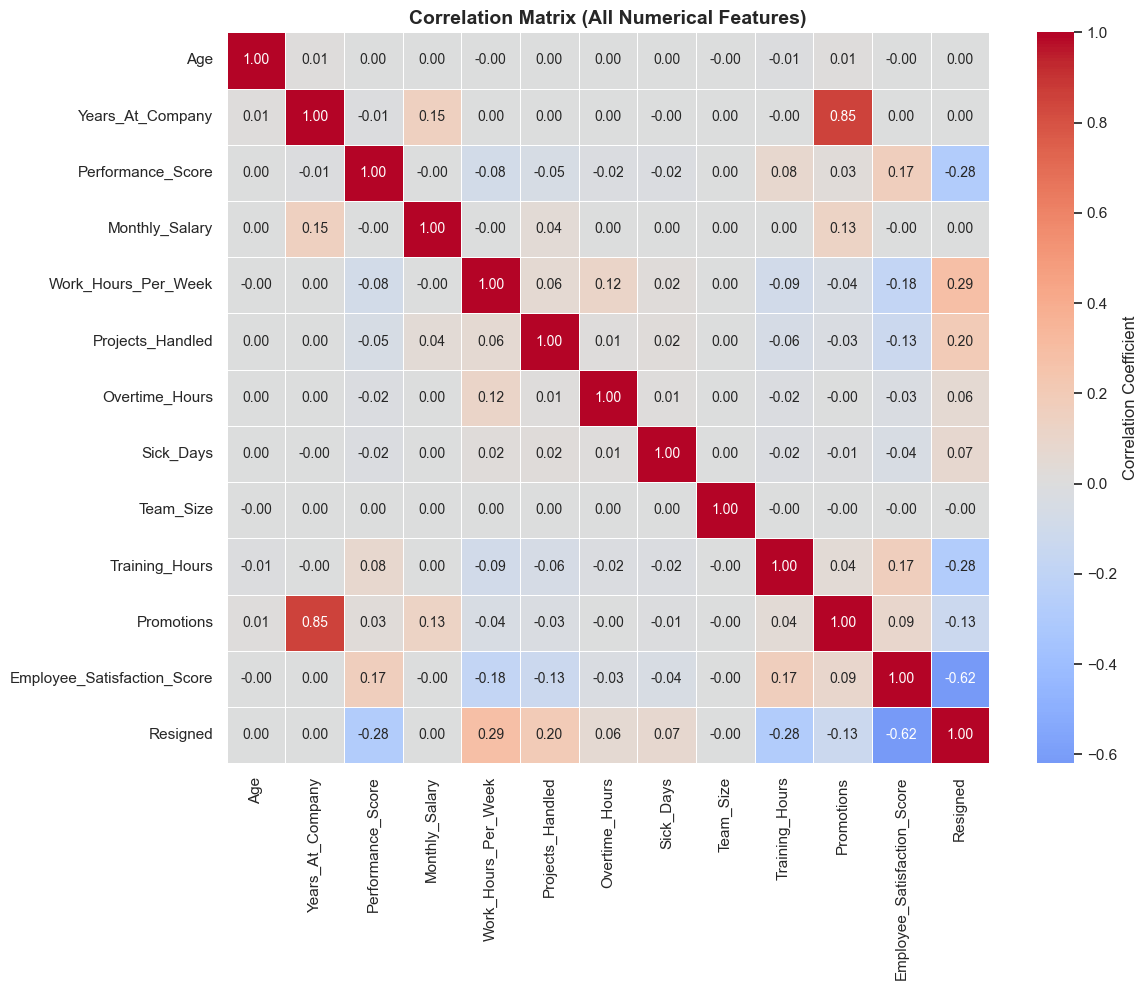

2026-02-03 17:04:32,297 | INFO | ✅ Saved Feature Correlation with Target: outputs/03b_feature_correlation_with_attrition.png


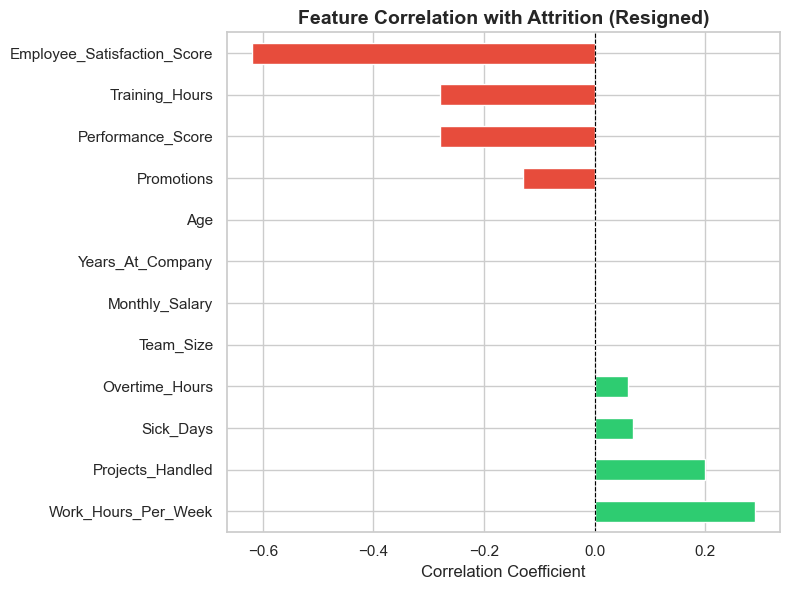

2026-02-03 17:04:32,493 | INFO | === CATEGORICAL FEATURES VS ATTRITION ===


,Feature,Chi2,P-Value,Significant
0,Department,9.179500,0.327400,No
1,Gender,0.319600,0.852300,No
2,Job_Title,2.716300,0.843500,No
3,Education_Level,0.554100,0.906800,No
4,Remote_Work_Frequency,0.803900,0.937900,No


c:\Users\User\FYP System Development\modules\eda.py:217: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attr_rate.index, y=attr_rate.values, ax=axes[idx], palette=PLOT_CONFIG["cmap"])
c:\Users\User\FYP System Development\modules\eda.py:217: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attr_rate.index, y=attr_rate.values, ax=axes[idx], palette=PLOT_CONFIG["cmap"])
c:\Users\User\FYP System Development\modules\eda.py:217: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attr_rate.index, y=attr_rate.values, ax=axes[idx], palette=PLOT_CONFIG["

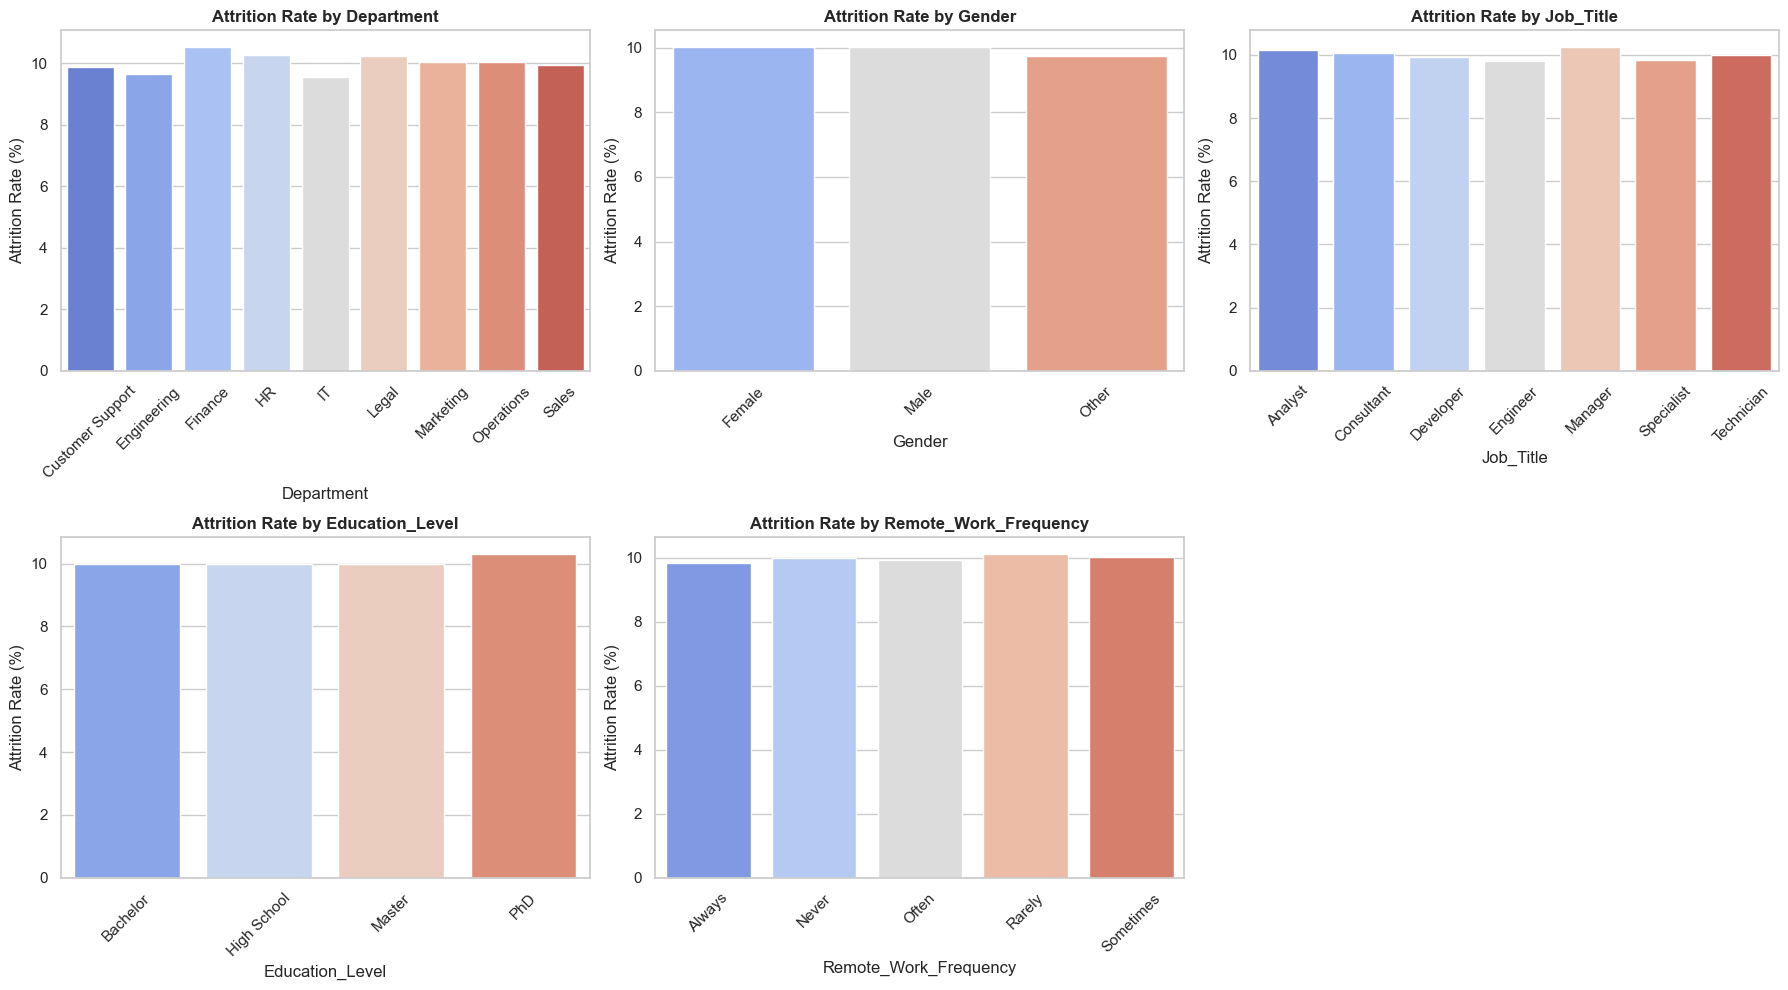

2026-02-03 17:04:35,151 | INFO | === SATISFACTION & PERFORMANCE ANALYSIS ===


,Employee_Satisfaction_Score,Performance_Score
Resigned,,
0,7.490000,3.700000
1,4.320000,3.100000


2026-02-03 17:04:35,263 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
c:\Users\User\FYP System Development\modules\eda.py:248: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Resigned", y="Employee_Satisfaction_Score",
2026-02-03 17:04:35,369 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-02-03 17:04:36,206 | INFO | Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
c:\Users\User\FYP 

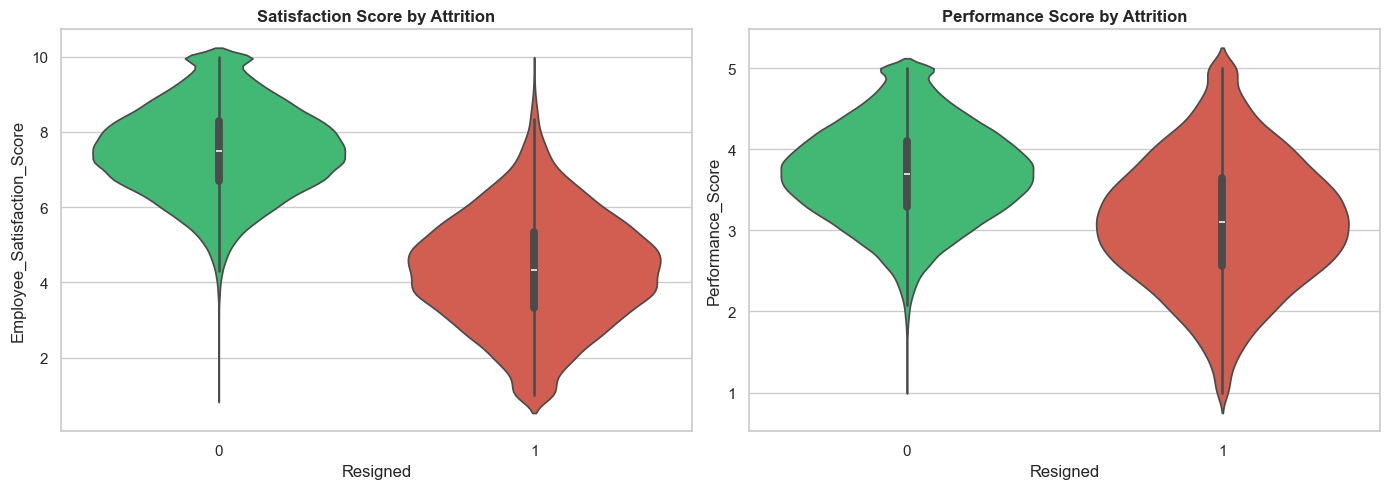

2026-02-03 17:04:37,957 | INFO | === WORKLOAD INTENSITY ANALYSIS ===
c:\Users\User\FYP System Development\modules\eda.py:274: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  workload_attr = df.groupby("Workload_Category")["Resigned"].agg(["sum", "count", "mean"])


,sum,count,mean,Attrition_Rate_%
Workload_Category,,,,
Low (<35h),833,33228,0.030000,2.510000
Normal (35-40h),3657,44438,0.080000,8.230000
High (40-45h),4170,19615,0.210000,21.260000
Very High (>45h),1350,2719,0.500000,49.650000


c:\Users\User\FYP System Development\modules\eda.py:280: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Workload_Category", data=df, ax=axes[0], palette=PLOT_CONFIG["cmap"])
c:\Users\User\FYP System Development\modules\eda.py:284: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=workload_attr.index, y=workload_attr["Attrition_Rate_%"],
2026-02-03 17:04:38,933 | INFO | ✅ Saved Workload Intensity Analysis: outputs/06_workload_intensity.png


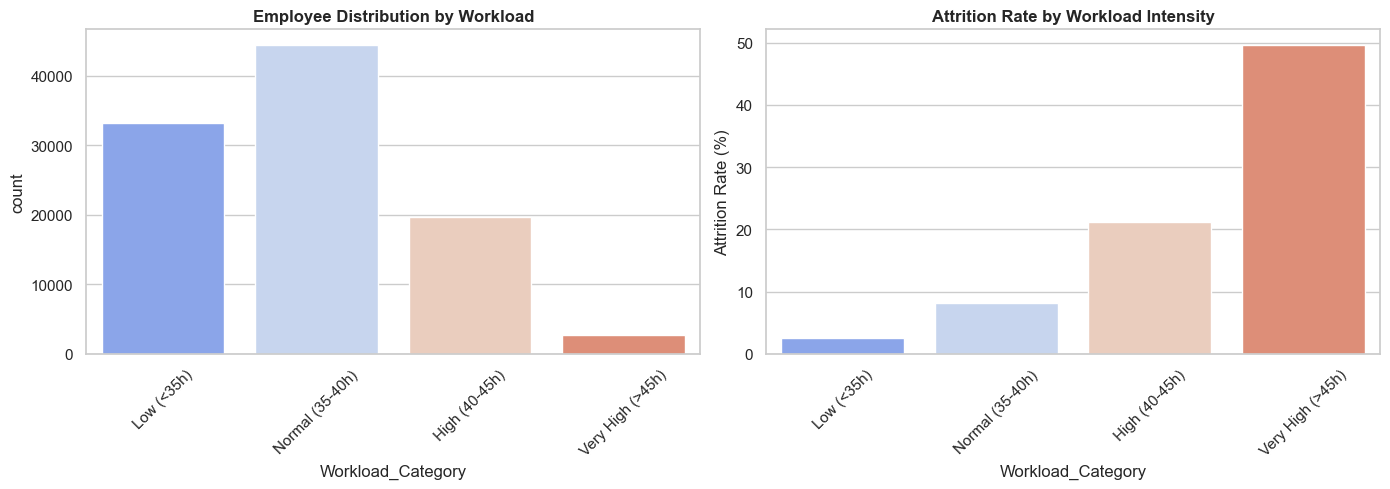

2026-02-03 17:04:39,189 | INFO | ================================================================================
2026-02-03 17:04:39,190 | INFO | ✅ INITIAL EDA COMPLETED SUCCESSFULLY
2026-02-03 17:04:39,191 | INFO | ================================================================================


In [17]:
# Perform EDA

eda_results = eda.perform_eda(df_clean.copy(), phase = "initial")

## Phase 5: Feature Engineering & Selection

**Objective:** Create workload-related features and identify the most influential predictors.

**Key Activities:**
- Engineer 12 new workload features:
  - Workload Intensity Score
  - Overwork/Underutilization Flags
  - Overtime Ratio
  - Project Load per Hour
  - Burnout Risk Score
  - Work-Life Balance Score
  - Tenure-Performance Ratio
  - Training Adequacy
  - Salary-Performance Gap
  - Age/Tenure Categories
- Encode categorical variables (one-hot encoding)
- Feature selection using:
  - Random Forest importance
  - Mutual Information
  - ANOVA F-statistic
  - Consensus ranking

**Rationale:**
- Workload features capture nuanced patterns (not just raw hours)
- Multiple selection methods ensure robust feature identification
- Consensus approach reduces method-specific bias

In [11]:
# Encoding now happens after the split (see next cell).


,Age,Years_At_Company,Education_Level,Performance_Score,Monthly_Salary,Work_Hours_Per_Week,Projects_Handled,Overtime_Hours,Sick_Days,Remote_Work_Frequency,Team_Size,Training_Hours,Promotions,Employee_Satisfaction_Score,Resigned,Workload_Intensity,Is_Overworked,Is_Underutilized,Overtime_Ratio,Project_Load,Burnout_Risk,Work_Life_Balance,Tenure_Performance_Ratio,Training_Per_Year,Salary_Performance_Gap,Age_Group,Tenure_Category,Department_Customer Support,Department_Engineering,Department_Finance,Department_HR,Department_IT,Department_Legal,Department_Marketing,Department_Operations,Department_Sales,Gender_Female,Gender_Male,Gender_Other,Job_Title_Analyst,Job_Title_Consultant,Job_Title_Developer,Job_Title_Engineer,Job_Title_Manager,Job_Title_Specialist,Job_Title_Technician
0,55,2,1,3.69,4523.03,39.8,4,144.0,1,2,8,28.2,1,7.04,0,0.759929,0,0,0.904523,0.100503,0.3,2.800,0.527704,9.400000,-0.726040,4,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0
1,29,0,1,3.38,7290.79,37.9,2,0.6,3,4,4,19.2,0,7.99,0,0.423008,0,0,0.003958,0.052770,0.0,9.970,0.000000,19.200000,0.593370,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0
2,55,8,1,3.76,8114.38,36.9,2,0.3,3,2,7,17.4,2,8.17,0,0.412433,0,0,0.002033,0.054201,0.0,9.985,2.072539,1.933333,0.247177,4,3,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0
3,48,7,2,4.41,5952.56,37.0,2,1.1,5,3,4,24.4,2,5.51,0,0.414967,0,0,0.007432,0.054054,0.2,9.945,1.552106,3.050000,-1.421466,3,3,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
4,36,3,2,4.17,5093.78,46.3,5,3.8,2,1,3,17.5,1,9.78,0,0.577432,1,0,0.020518,0.107991,0.6,6.660,0.702576,4.375000,-1.304905,2,2,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,27,1,2,3.72,6232.82,41.7,2,1.2,2,4,7,18.2,0,8.03,0,0.462159,0,0,0.007194,0.047962,0.0,9.090,0.261780,9.100000,-0.257502,1,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
99996,36,6,3,2.91,6023.42,36.7,3,0.1,1,2,8,7.8,2,5.90,1,0.431478,0,0,0.000681,0.081744,0.0,9.995,1.993355,1.114286,0.946571,2,3,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0
99997,53,8,1,3.48,5875.00,26.1,1,3.2,2,3,7,20.6,3,8.39,0,0.288567,0,1,0.030651,0.038314,0.3,9.840,2.234637,2.288889,0.010089,4,3,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0
99998,27,9,1,3.20,5199.21,33.1,3,0.0,2,0,12,21.6,3,5.59,0,0.395286,0,1,0.000000,0.090634,0.0,10.000,2.727273,2.160000,0.244396,1,3,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0


2026-02-03 17:05:32,753 | INFO | ==== DATA PARTITION PIPELINE START ====
2026-02-03 17:05:32,757 | INFO | Starting data partitioning...


2026-02-03 17:05:32,919 | INFO | Data successfully partitioned: Train=65000, Val=15000, Test=20000


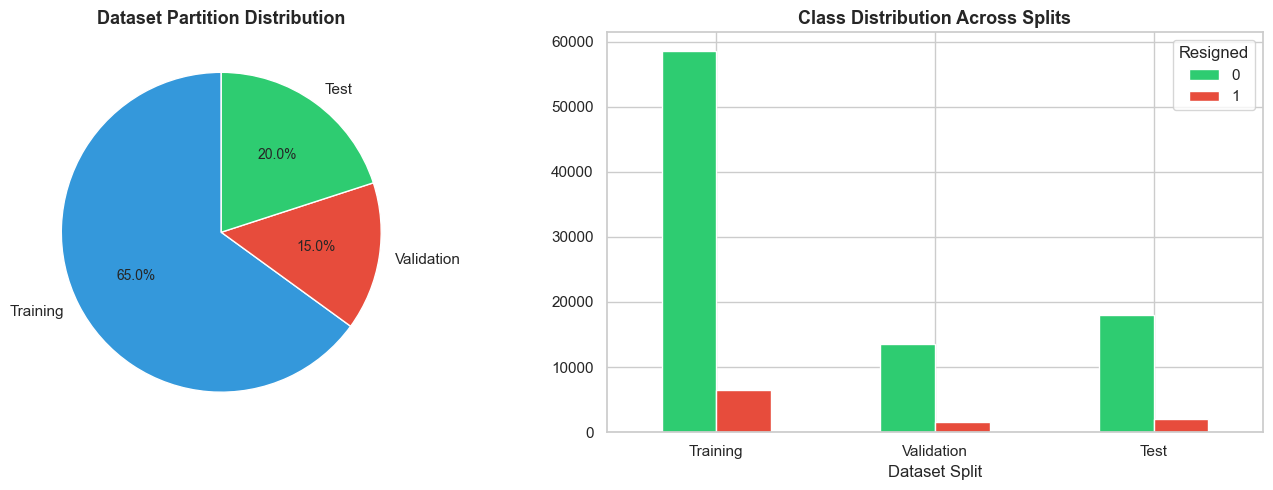

,Split,Samples,Class_0,Class_1,Attrition_Rate_%,Percentage
0,Training,65000,58493,6507,10.010000,65.000000
1,Validation,15000,13499,1501,10.010000,15.000000
2,Test,20000,17998,2002,10.010000,20.000000


2026-02-03 17:05:33,757 | INFO | Stratification check: max class-ratio diff = 0.00%
2026-02-03 17:05:33,758 | INFO | ==== DATA PARTITION PIPELINE COMPLETE ====



FEATURE ENGINEERING: Workload-Based Features
✓ Created 12 new engineered features. Dataset shape: (65000, 32)

FEATURE ENGINEERING: Workload-Based Features
✓ Created 12 new engineered features. Dataset shape: (15000, 32)

FEATURE ENGINEERING: Workload-Based Features
✓ Created 12 new engineered features. Dataset shape: (20000, 32)

ENCODING CATEGORICAL FEATURES
✓ Ordinal encoded: Education_Level
✓ Ordinal encoded: Remote_Work_Frequency
✓ One-hot encoded nominal features: Department, Gender, Job_Title
✓ Encoding complete. Total features: 45

ENCODING CATEGORICAL FEATURES
✓ Ordinal encoded: Education_Level
✓ Ordinal encoded: Remote_Work_Frequency
✓ One-hot encoded nominal features: Department, Gender, Job_Title
✓ Encoding complete. Total features: 45

ENCODING CATEGORICAL FEATURES
✓ Ordinal encoded: Education_Level
✓ Ordinal encoded: Remote_Work_Frequency
✓ One-hot encoded nominal features: Department, Gender, Job_Title
✓ Encoding complete. Total features: 45

FEATURE SELECTION: Random F

Feature,Importance
Employee_Satisfaction_Score,0.370951
Burnout_Risk,0.080962
Performance_Score,0.064185
Training_Hours,0.056943
Workload_Intensity,0.052281
Salary_Performance_Gap,0.036564
Work_Hours_Per_Week,0.029966
Training_Per_Year,0.029561
Tenure_Performance_Ratio,0.025847
Work_Life_Balance,0.024396


c:\Users\User\FYP System Development\modules\feature_engineering.py:238: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


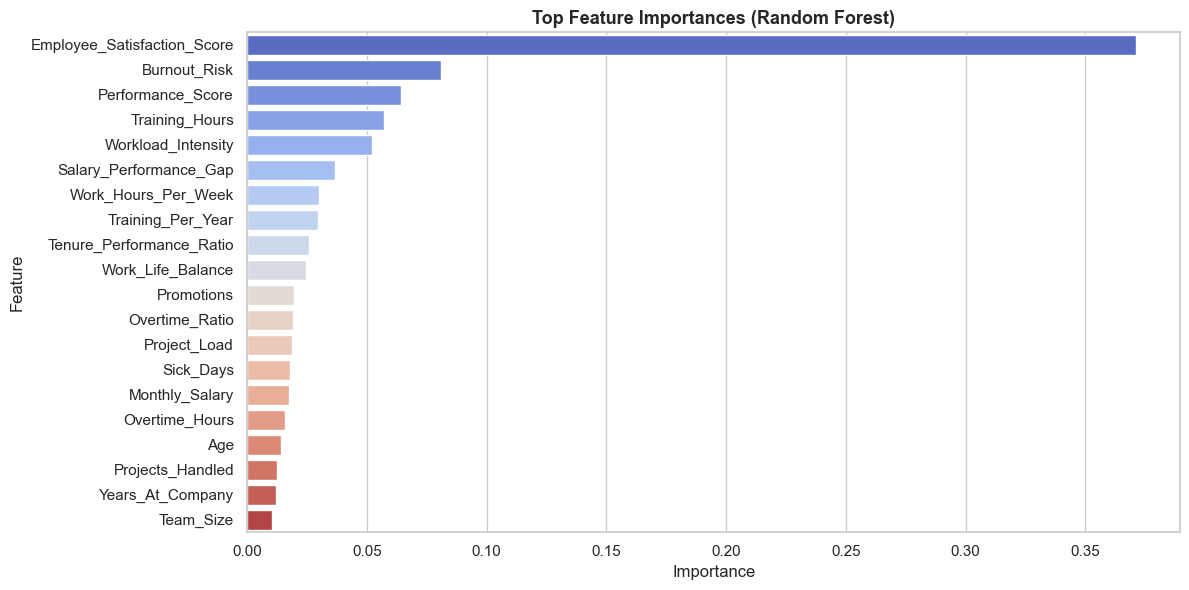


FEATURE SELECTION: Mutual Information


Feature,MI_Score
Employee_Satisfaction_Score,0.187764
Burnout_Risk,0.090085
Workload_Intensity,0.055726
Work_Hours_Per_Week,0.045708
Performance_Score,0.045219
Training_Hours,0.044983
Project_Load,0.042707
Work_Life_Balance,0.034743
Overtime_Ratio,0.031194
Salary_Performance_Gap,0.029281


c:\Users\User\FYP System Development\modules\feature_engineering.py:267: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mi_df.head(top_k), x="MI_Score", y="Feature", palette="coolwarm")


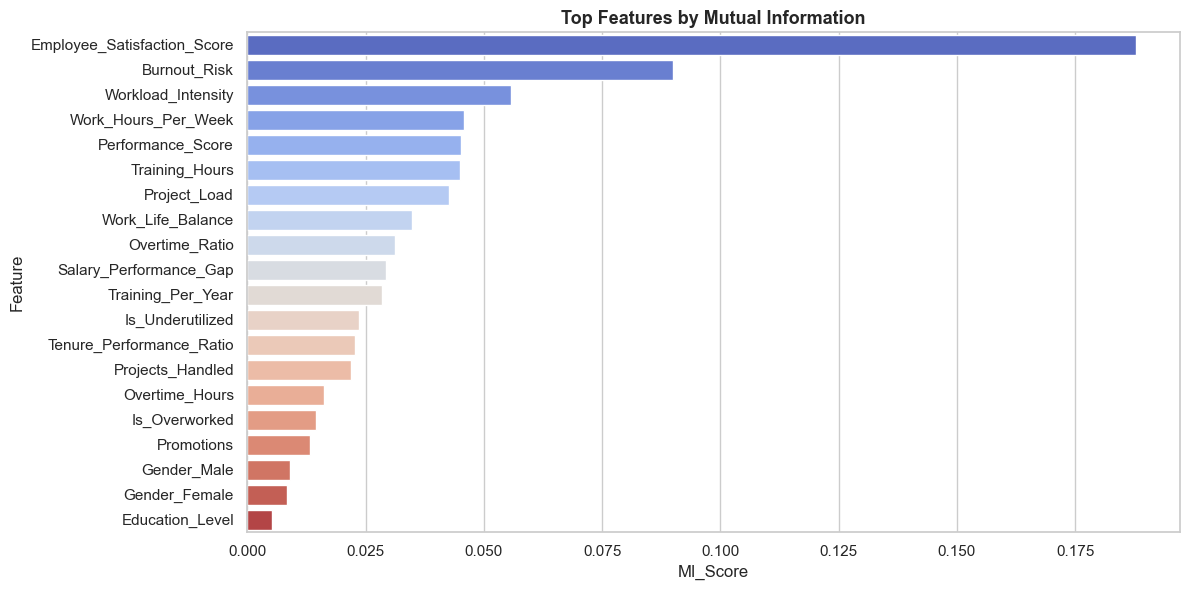


FEATURE SELECTION: ANOVA F-Statistic


Feature,F_Score,P_Value
Employee_Satisfaction_Score,40016.596250,0.000000e+00
Burnout_Risk,12750.364715,0.000000e+00
Workload_Intensity,8346.171991,0.000000e+00
Work_Hours_Per_Week,5998.370650,0.000000e+00
Work_Life_Balance,5866.405563,0.000000e+00
Training_Hours,5613.525346,0.000000e+00
Performance_Score,5565.990705,0.000000e+00
Is_Overworked,3221.760281,0.000000e+00
Projects_Handled,2798.107036,0.000000e+00
Salary_Performance_Gap,2796.012206,0.000000e+00



CONSENSUS FEATURE SELECTION

Top 20 Consensus Features:
                    Feature  RF_Rank  MI_Rank  F_Rank  Avg_Rank
Employee_Satisfaction_Score        1        1       1  1.000000
               Burnout_Risk        2        2       2  2.000000
         Workload_Intensity        5        3       3  3.666667
          Performance_Score        3        5       7  5.000000
        Work_Hours_Per_Week        7        4       4  5.000000
             Training_Hours        4        6       6  5.333333
          Work_Life_Balance       10        8       5  7.666667
     Salary_Performance_Gap        6       10      10  8.666667
          Training_Per_Year        8       11      14 11.000000
               Project_Load       13        7      13 11.000000
   Tenure_Performance_Ratio        9       13      15 12.333333
             Overtime_Ratio       12        9      18 13.000000
                 Promotions       11       17      12 13.333333
           Projects_Handled       18       14  

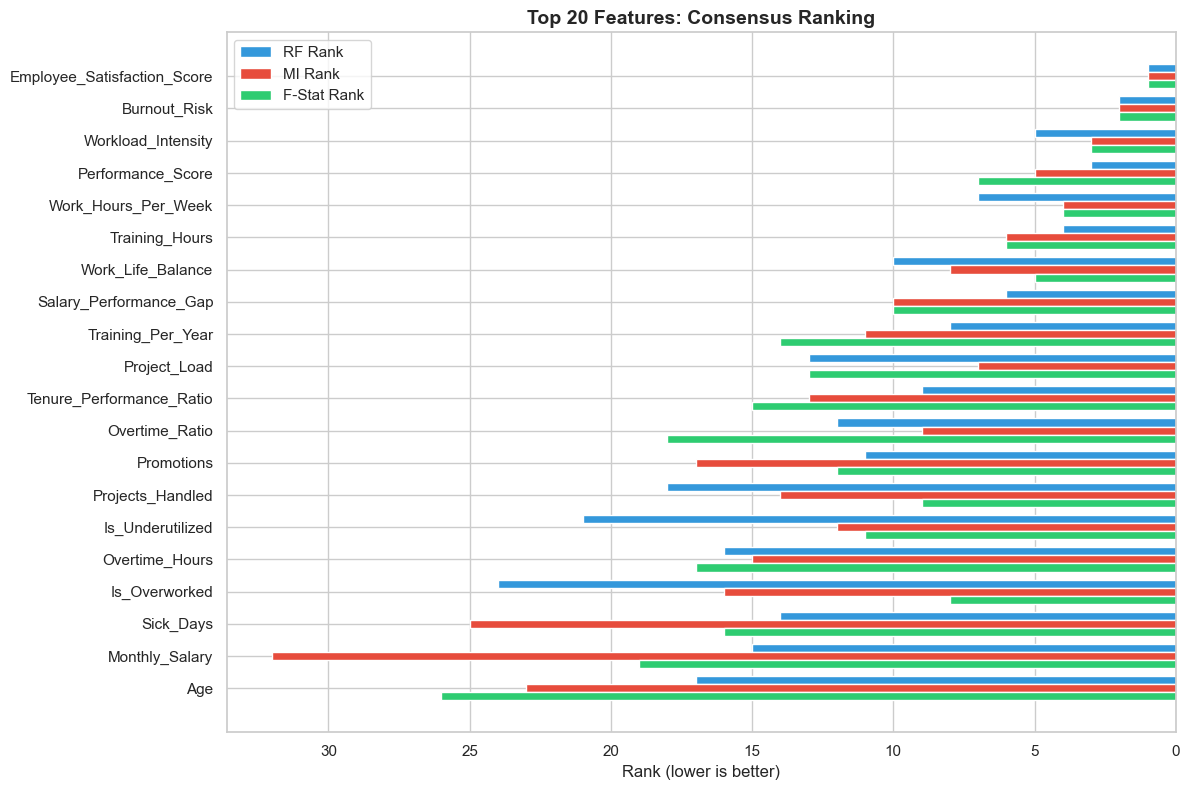

2026-02-03 17:06:04,179 | INFO | Starting imbalance handling pipeline...
2026-02-03 17:06:04,180 | INFO | Analyzing class distribution...


,Class,Count,Percentage (%)
0,0,58493,89.99
1,1,6507,10.01


2026-02-03 17:06:04,188 | INFO | Imbalance ratio: 8.99:1
2026-02-03 17:06:04,189 | WARNING | Severe imbalance detected (ratio > 3:1)
2026-02-03 17:06:04,195 | INFO | Applying SMOTE...
2026-02-03 17:06:08,882 | INFO | SMOTE completed. Before: Counter({0: 58493, 1: 6507}) | After: Counter({0: 58493, 1: 58493})
2026-02-03 17:06:08,885 | INFO | Resampled dataset shape: (116986, 21)


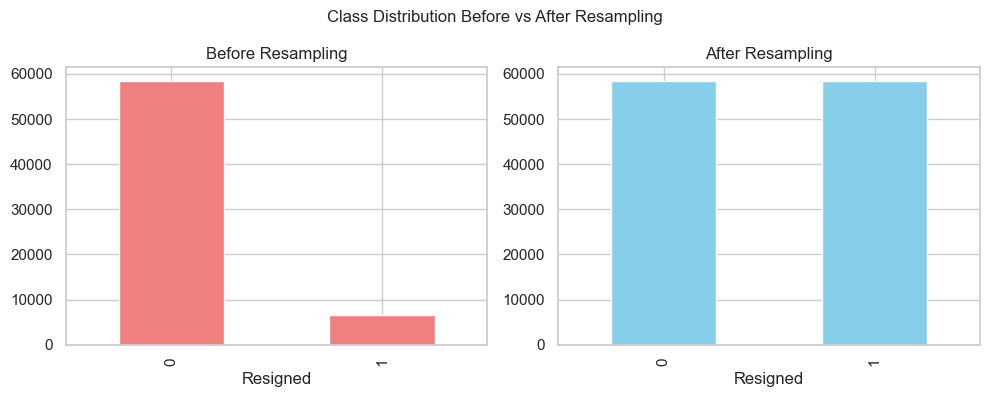

2026-02-03 17:06:14,065 | INFO | Saved train data → data/train_data.csv ((116986, 21))
2026-02-03 17:06:14,664 | INFO | Saved val data → data/val_data.csv ((15000, 21))
2026-02-03 17:06:15,453 | INFO | Saved test data → data/test_data.csv ((20000, 21))
2026-02-03 17:06:15,459 | INFO | Partition metadata saved as 'partition_metadata.json'.



OK: Data split, feature-selected, scaled, SMOTE applied to train only.


In [18]:
# Split first (no leakage)
from modules import feature_engineering, data_partition, data_transformation, imbalance_handling
from modules.data_partition import save_partitioned_data
import json
import joblib

partition_results = data_partition.create_data_partition(
    df_clean.copy(),
    target_col='Resigned',
    test_size=0.20,
    val_size=0.15,
    random_state=42,
    save_data=False,
    output_dir='data'
)

# Rebuild split DataFrames
X_train_raw = partition_results['X_train']
X_val_raw = partition_results['X_val']
X_test_raw = partition_results['X_test']

y_train_raw = partition_results['y_train']
y_val_raw = partition_results['y_val']
y_test_raw = partition_results['y_test']

df_train_raw = X_train_raw.copy()
df_train_raw['Resigned'] = y_train_raw

df_val_raw = X_val_raw.copy()
df_val_raw['Resigned'] = y_val_raw

df_test_raw = X_test_raw.copy()
df_test_raw['Resigned'] = y_test_raw

# Feature engineering (fit params on train, apply to val/test)
workload_params = feature_engineering.fit_workload_feature_params(df_train_raw)

df_train_eng = feature_engineering.apply_workload_features(df_train_raw, workload_params)
df_val_eng = feature_engineering.apply_workload_features(df_val_raw, workload_params)
df_test_eng = feature_engineering.apply_workload_features(df_test_raw, workload_params)

# Encode categorical features

df_train_enc = feature_engineering.encode_categorical_features(df_train_eng)
df_val_enc = feature_engineering.encode_categorical_features(df_val_eng)
df_test_enc = feature_engineering.encode_categorical_features(df_test_eng)

# Align encoded columns to training schema

df_val_enc = feature_engineering.align_encoded_columns(df_train_enc, df_val_enc, target_col='Resigned')
df_test_enc = feature_engineering.align_encoded_columns(df_train_enc, df_test_enc, target_col='Resigned')

# Feature selection on training data only

top_k = 20
rf_imp = feature_engineering.select_features_importance(df_train_enc, target_col='Resigned', top_k=top_k)
mi_imp = feature_engineering.select_features_mutual_info(df_train_enc, target_col='Resigned', top_k=top_k)
f_imp = feature_engineering.select_features_statistical(df_train_enc, target_col='Resigned', top_k=top_k)
consensus = feature_engineering.get_consensus_features(rf_imp, mi_imp, f_imp, top_k=top_k)

selected_features = consensus['Feature'].head(top_k).tolist()

# Reduce to selected features

df_train_sel = df_train_enc.reindex(columns=selected_features + ['Resigned'])
df_val_sel = df_val_enc.reindex(columns=selected_features + ['Resigned'], fill_value=0)
df_test_sel = df_test_enc.reindex(columns=selected_features + ['Resigned'], fill_value=0)

# Scale using training data only

scaler, numeric_cols = data_transformation.fit_scaler(df_train_sel, target_col='Resigned', method='standard')

df_train_scaled = data_transformation.transform_with_scaler(df_train_sel, scaler, numeric_cols, target_col='Resigned')
df_val_scaled = data_transformation.transform_with_scaler(df_val_sel, scaler, numeric_cols, target_col='Resigned')
df_test_scaled = data_transformation.transform_with_scaler(df_test_sel, scaler, numeric_cols, target_col='Resigned')

# Apply SMOTE only on training set (after scaling)

feature_cols = [col for col in df_train_scaled.columns if col != 'Resigned']

df_train_bal, X_balanced, y_balanced = imbalance_handling.handle_imbalance(
    df_train_scaled.copy(),
    feature_cols=feature_cols,
    target_col='Resigned',
    method='smote',
    random_state=42
)

# Save artifacts
joblib.dump(scaler, 'data/scaler.pkl')
with open('data/selected_features.json', 'w') as f:
    json.dump(selected_features, f, indent=2)

# Save final datasets

X_train_final = df_train_bal.drop(columns=['Resigned'])
y_train_final = df_train_bal['Resigned']

X_val_final = df_val_scaled.drop(columns=['Resigned'])
y_val_final = df_val_scaled['Resigned']

X_test_final = df_test_scaled.drop(columns=['Resigned'])
y_test_final = df_test_scaled['Resigned']

save_partitioned_data(
    X_train_final, X_val_final, X_test_final,
    y_train_final, y_val_final, y_test_final,
    output_dir='data',
    random_state=42
)

print("\nOK: Data split, feature-selected, scaled, SMOTE applied to train only.")


---
## Phase 4 (Continued): Apply Imbalance Handling

**Now that features are engineered, we apply SMOTE to the encoded dataset.**

2025-11-19 03:04:28,913 | INFO | Starting imbalance handling pipeline...
2025-11-19 03:04:28,914 | INFO | Analyzing class distribution...


,Class,Count,Percentage (%)
0,0,89990,89.99
1,1,10010,10.01


2025-11-19 03:04:28,920 | INFO | Imbalance ratio: 8.99:1
2025-11-19 03:04:28,921 | WARNING | Severe imbalance detected (ratio > 3:1)
2025-11-19 03:04:28,931 | INFO | Applying SMOTE...
2025-11-19 03:04:29,750 | INFO | SMOTE completed. Before: Counter({0: 89990, 1: 10010}) | After: Counter({0: 89990, 1: 89990})
2025-11-19 03:04:29,753 | INFO | Resampled dataset shape: (179980, 46)


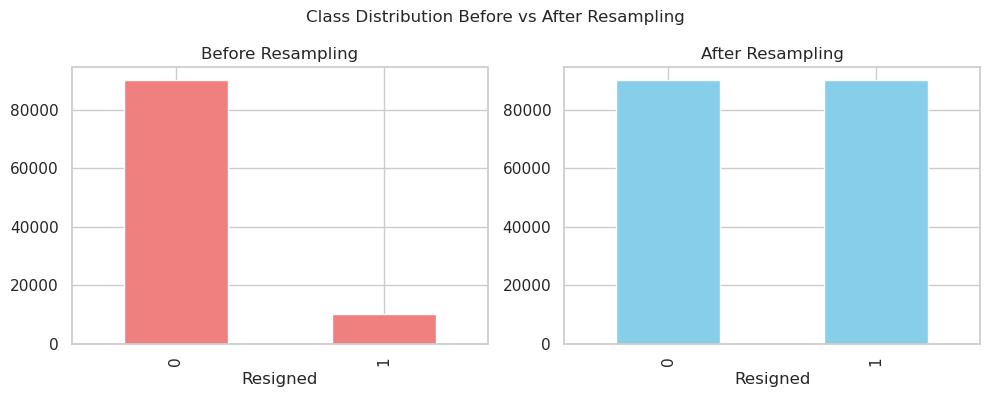


✓ Balanced data saved to: data/balanced_data.csv


In [7]:
# SMOTE moved earlier; see split-first pipeline cell.


---
## Phase 6: Data Transformation

**Objective:** Scale and normalize features for optimal model performance.

**Key Activities:**
- Compare scaling methods (Standard, MinMax, Robust)
- Apply StandardScaler (most common for ML)
- Visualize before/after distributions
- Analyze post-transformation correlations

**Rationale:**
- StandardScaler: Mean=0, Std=1 (required for many ML algorithms)
- Ensures features on comparable scales
- Improves convergence for gradient-based algorithms
- Maintains relative relationships between features


DATA TRANSFORMATION PIPELINE

COMPARING SCALING METHODS


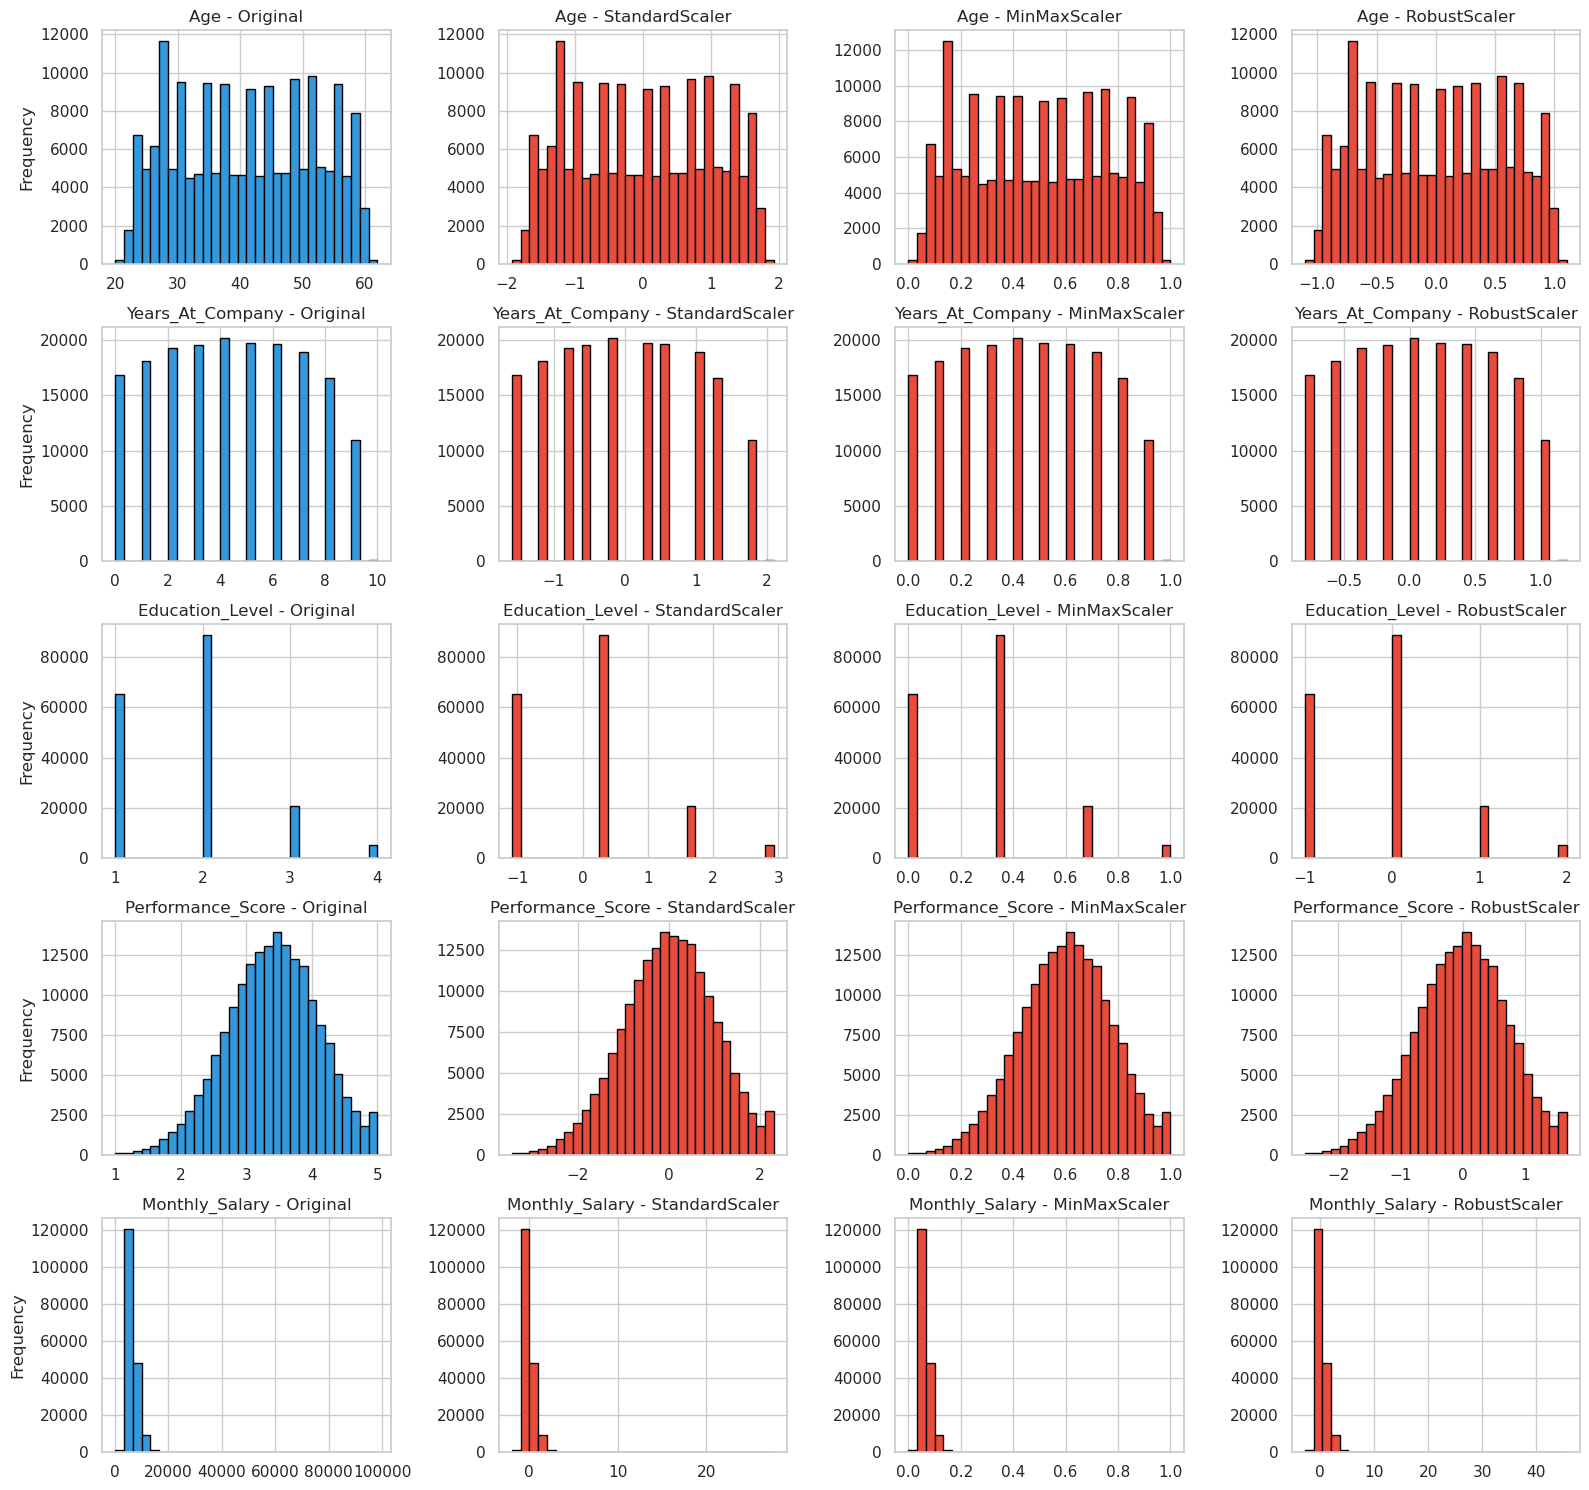


📊 Scaling Method Characteristics:
  - StandardScaler: Mean=0, Std=1 (sensitive to outliers)
  - MinMaxScaler: Range [0,1] (sensitive to outliers)
  - RobustScaler: Uses median & IQR (robust to outliers)

  Recommendation: StandardScaler (most common for ML)

APPLYING STANDARD SCALING

Scaling 45 numeric features...
✓ Scaling completed using StandardScaler

Scaled data statistics (first 5 features):
                Age  Years_At_Company  Education_Level  Performance_Score  Monthly_Salary
count  1.799800e+05      1.799800e+05     1.799800e+05       1.799800e+05    1.799800e+05
mean   7.272029e-17      1.642326e-16     1.465460e-16      -1.238061e-15    2.724839e-16
std    1.000003e+00      1.000003e+00     1.000003e+00       1.000003e+00    1.000003e+00
min   -1.925736e+00     -1.592626e+00    -1.083636e+00      -3.447435e+00   -1.918465e+00
25%   -9.160401e-01     -8.546932e-01    -1.083636e+00      -6.725556e-01   -4.270181e-01
50%    1.865596e-03     -1.167601e-01     2.548088e-01   

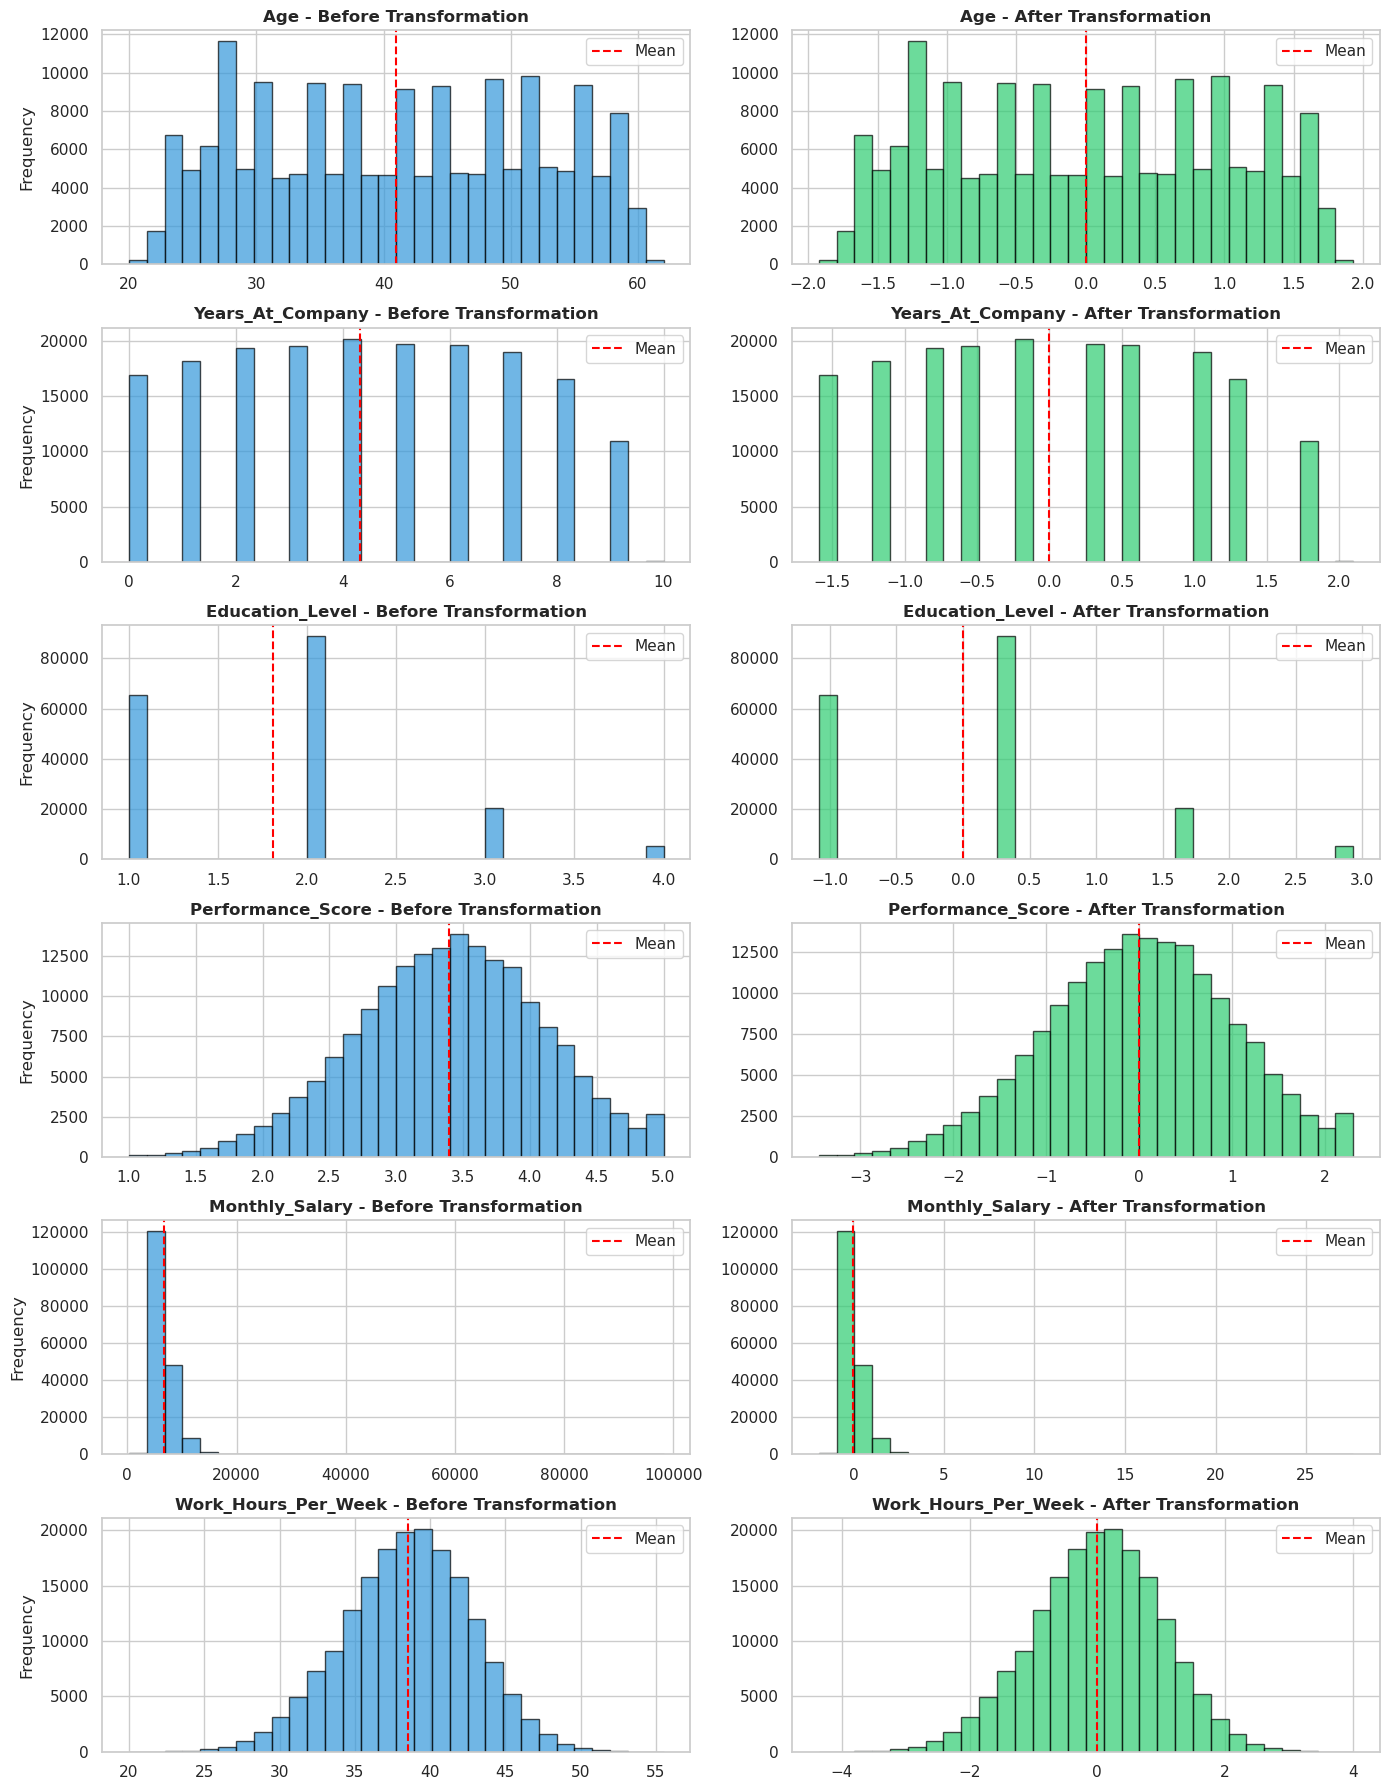

✓ Visualization completed

POST-TRANSFORMATION CORRELATION ANALYSIS

Top 15 correlations with Attrition (after transformation):
Resigned                    1.000000
Burnout_Risk                0.545489
Workload_Intensity          0.523073
Work_Hours_Per_Week         0.476543
Salary_Performance_Gap      0.317037
Projects_Handled            0.228775
Project_Load                0.218243
Tenure_Performance_Ratio    0.168665
Is_Overworked               0.090910
Overtime_Hours              0.077585
Overtime_Ratio              0.054247
Sick_Days                   0.003934
Monthly_Salary              0.002963
Age                        -0.011427
Job_Title_Manager          -0.056788
Name: Resigned, dtype: float64


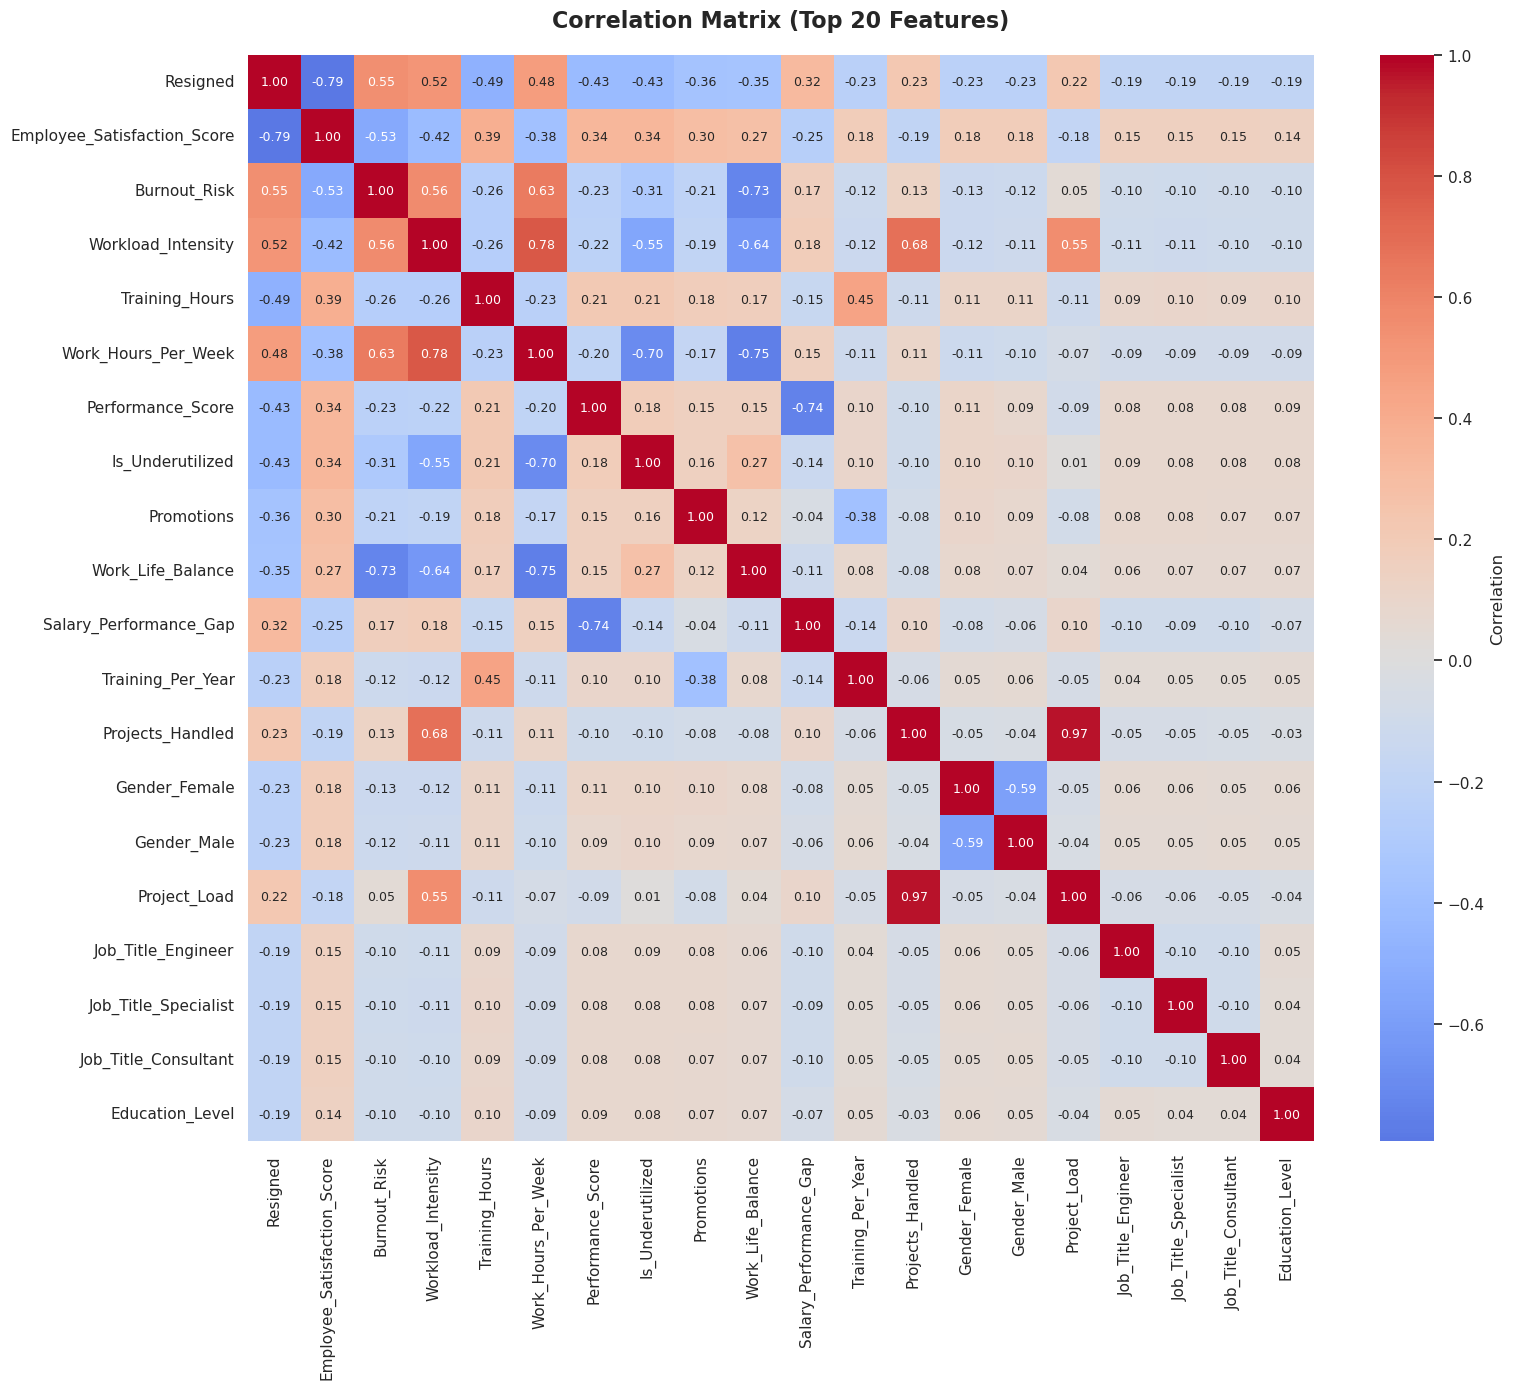

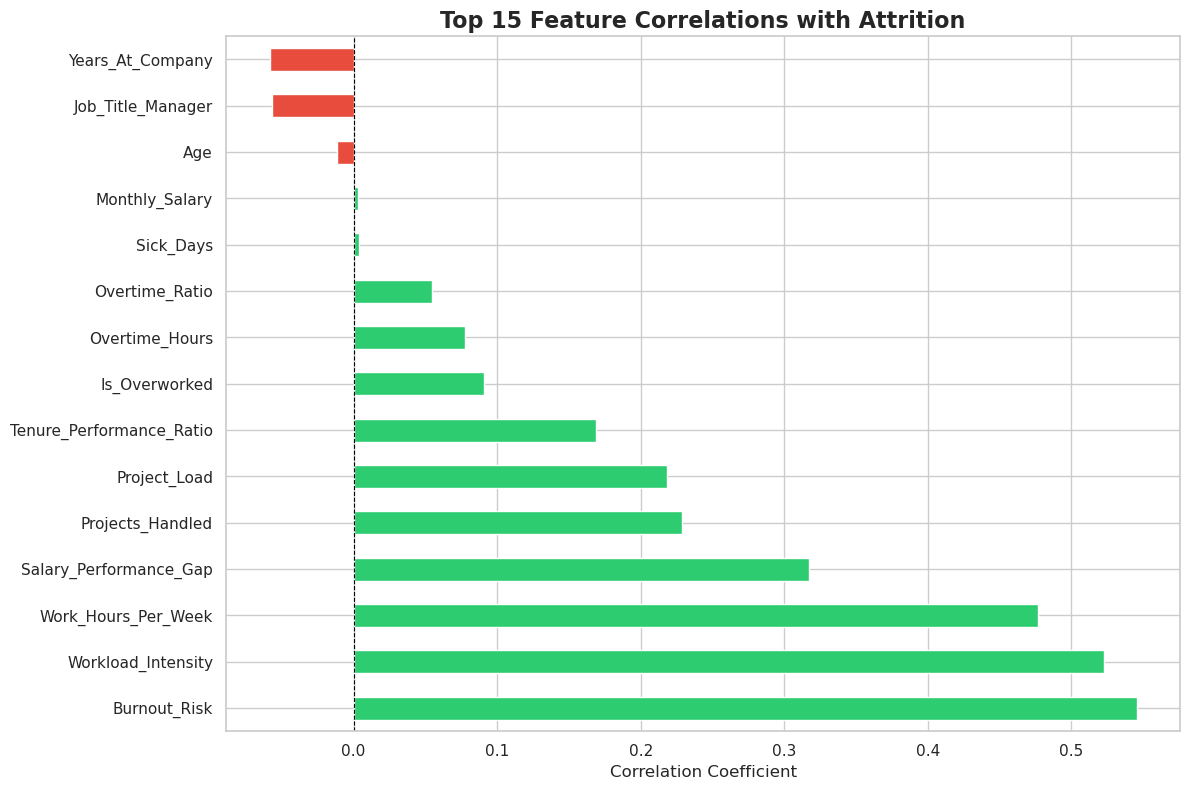


✓ DATA TRANSFORMATION COMPLETED
Transformed dataset shape: (179980, 46)
✓ Scaler saved to: data/scaler.pkl


In [8]:
# Scaling moved earlier; see split-first pipeline cell.


---
## Phase 6.5: Post-Transformation EDA

**Objective:** Inspect transformed data to ensure quality and readiness.

**Key Activities:**
- Re-run EDA on transformed dataset
- Compare with initial EDA results
- Validate feature distributions
- Confirm correlation patterns


STARTING POST-TRANSFORMATION EDA

DISTRIBUTION COMPARISON: Before vs After Transformation


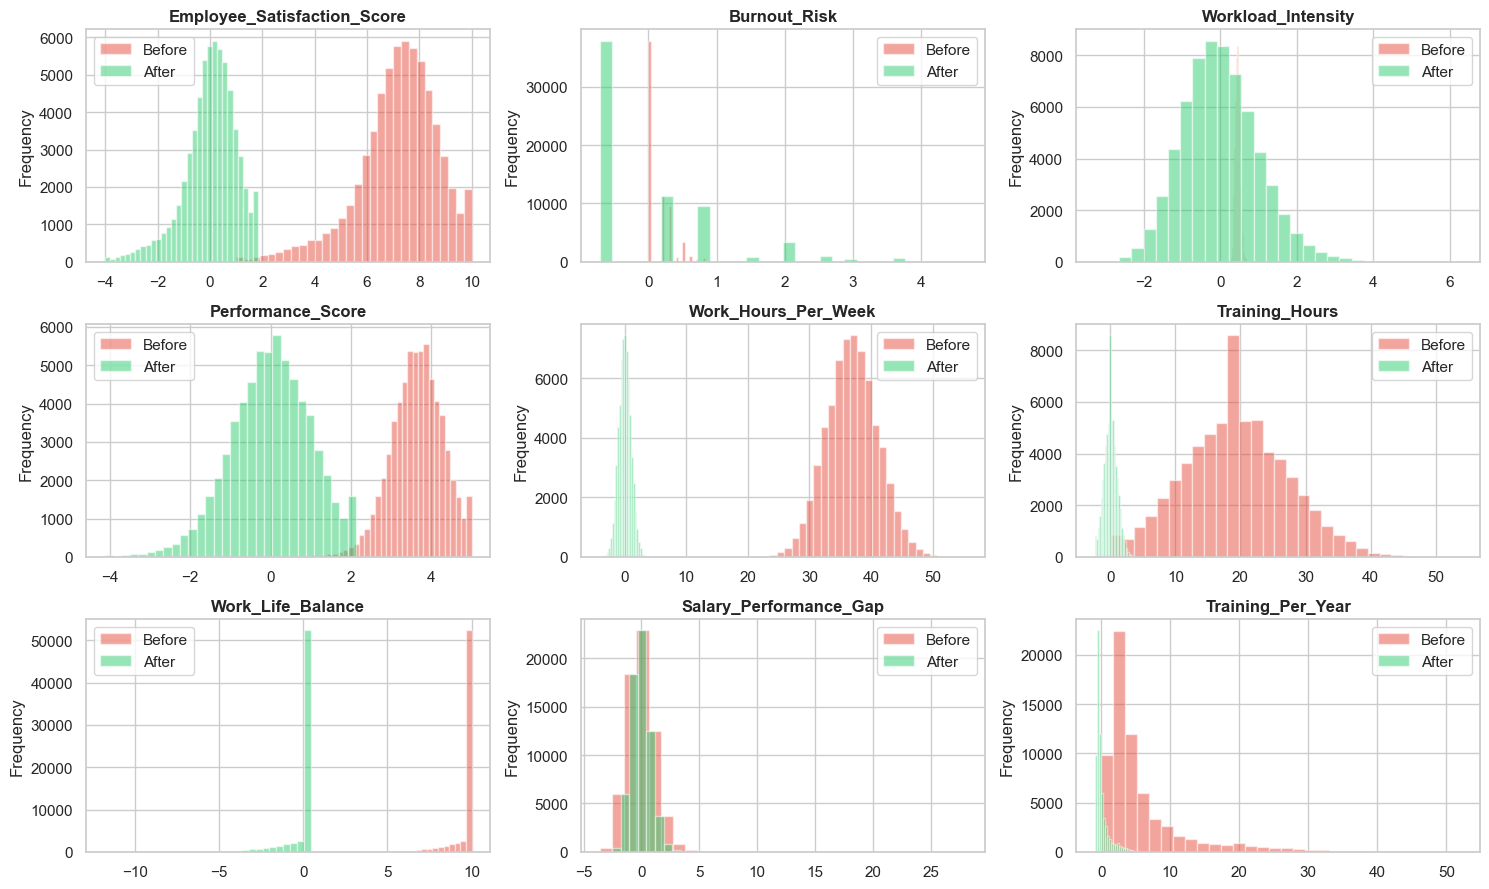

✓ Distribution comparison saved

SKEWNESS REDUCTION ANALYSIS

Top 10 Features with Skewness Reduction:
                    Feature  Skew_Before  Skew_After  Improvement
          Work_Life_Balance    -3.510716   -3.510716 4.440892e-15
             Overtime_Hours    17.574503   17.574503 3.552714e-15
        Work_Hours_Per_Week     0.049637    0.049637 3.545775e-15
         Workload_Intensity     0.460047    0.460047 2.609024e-15
Employee_Satisfaction_Score    -0.853693   -0.853693 2.553513e-15
             Monthly_Salary    10.466754   10.466754 1.776357e-15
               Project_Load     0.682821    0.682821 6.661338e-16
          Training_Per_Year     2.431701    2.431701 4.440892e-16
                        Age     0.026118    0.026118 3.469447e-18
     Salary_Performance_Gap     3.821723    3.821723 0.000000e+00


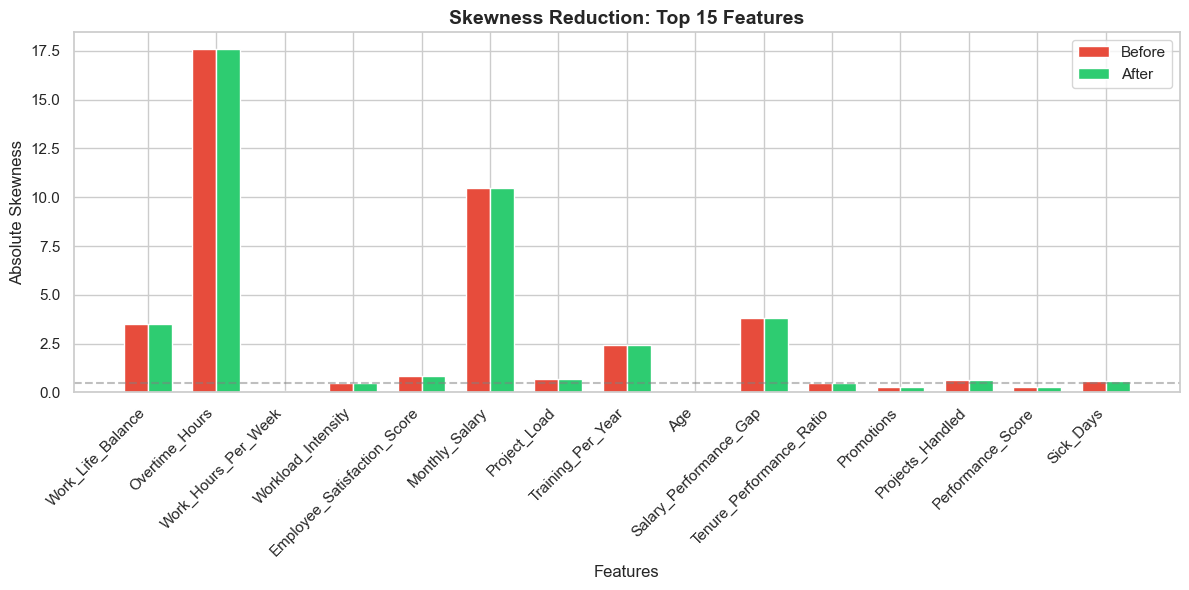


CORRELATION STRENGTH ANALYSIS

Top 15 Features by Correlation with Target:
                    Feature  Corr_Before  Corr_After        Change
Employee_Satisfaction_Score     0.617299    0.617299  1.776357e-15
               Burnout_Risk     0.404963    0.404963  4.996004e-15
         Workload_Intensity     0.337335    0.337335 -3.996803e-15
        Work_Hours_Per_Week     0.290669    0.290669  5.440093e-15
          Work_Life_Balance     0.287721    0.287721 -2.386980e-15
             Training_Hours     0.281955    0.281955  8.881784e-16
          Performance_Score     0.280853    0.280853  1.887379e-15
              Is_Overworked     0.217316    0.217316 -2.386980e-15
     Salary_Performance_Gap     0.203083    0.203083 -1.415534e-15
                 Promotions     0.134711    0.134711 -5.273559e-16
          Training_Per_Year     0.111605    0.111605  3.885781e-16
   Tenure_Performance_Ratio     0.102302    0.102302 -5.412337e-16
                  Sick_Days     0.070298    0.070298 

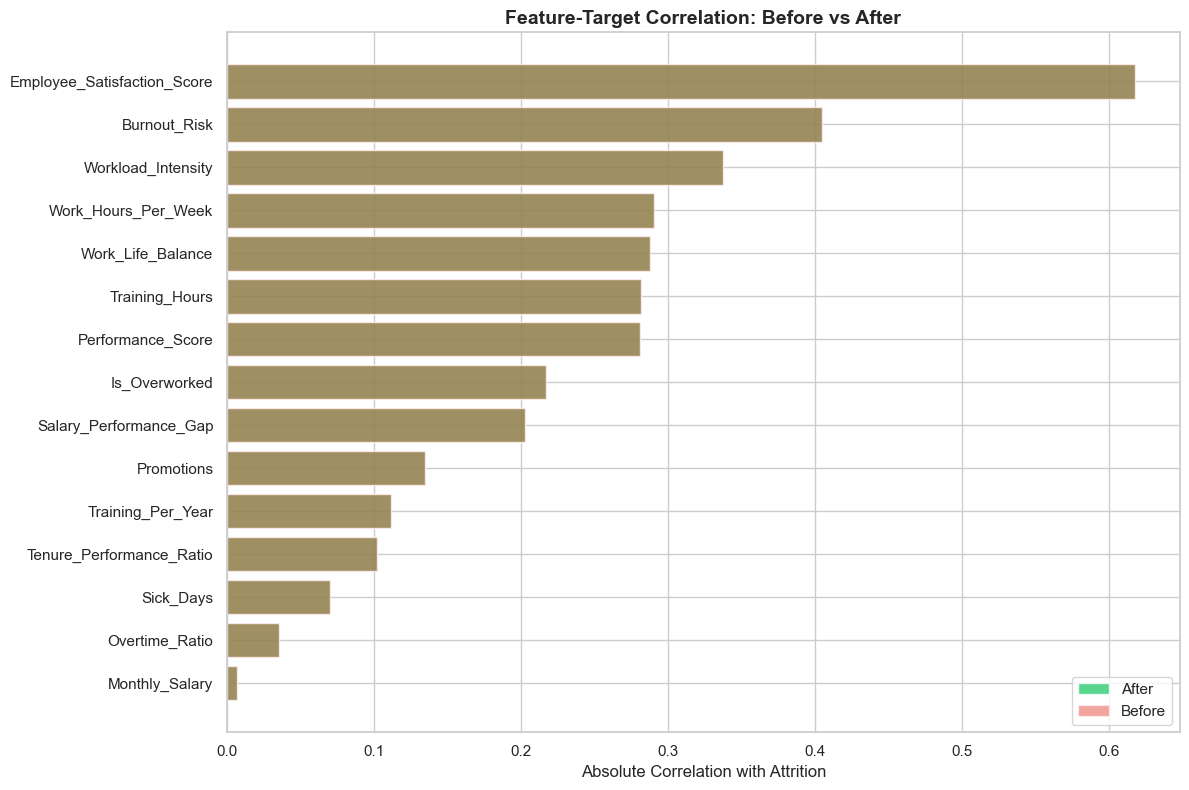


MULTICOLLINEARITY ANALYSIS

High correlation pairs (>0.8):
  Before: 2 pairs
  After: 2 pairs
  Reduction: 0 pairs

Remaining high correlations:
  Projects_Handled <-> Project_Load: 0.972
  Overtime_Hours <-> Overtime_Ratio: 0.993

CLASS SEPARABILITY ANALYSIS


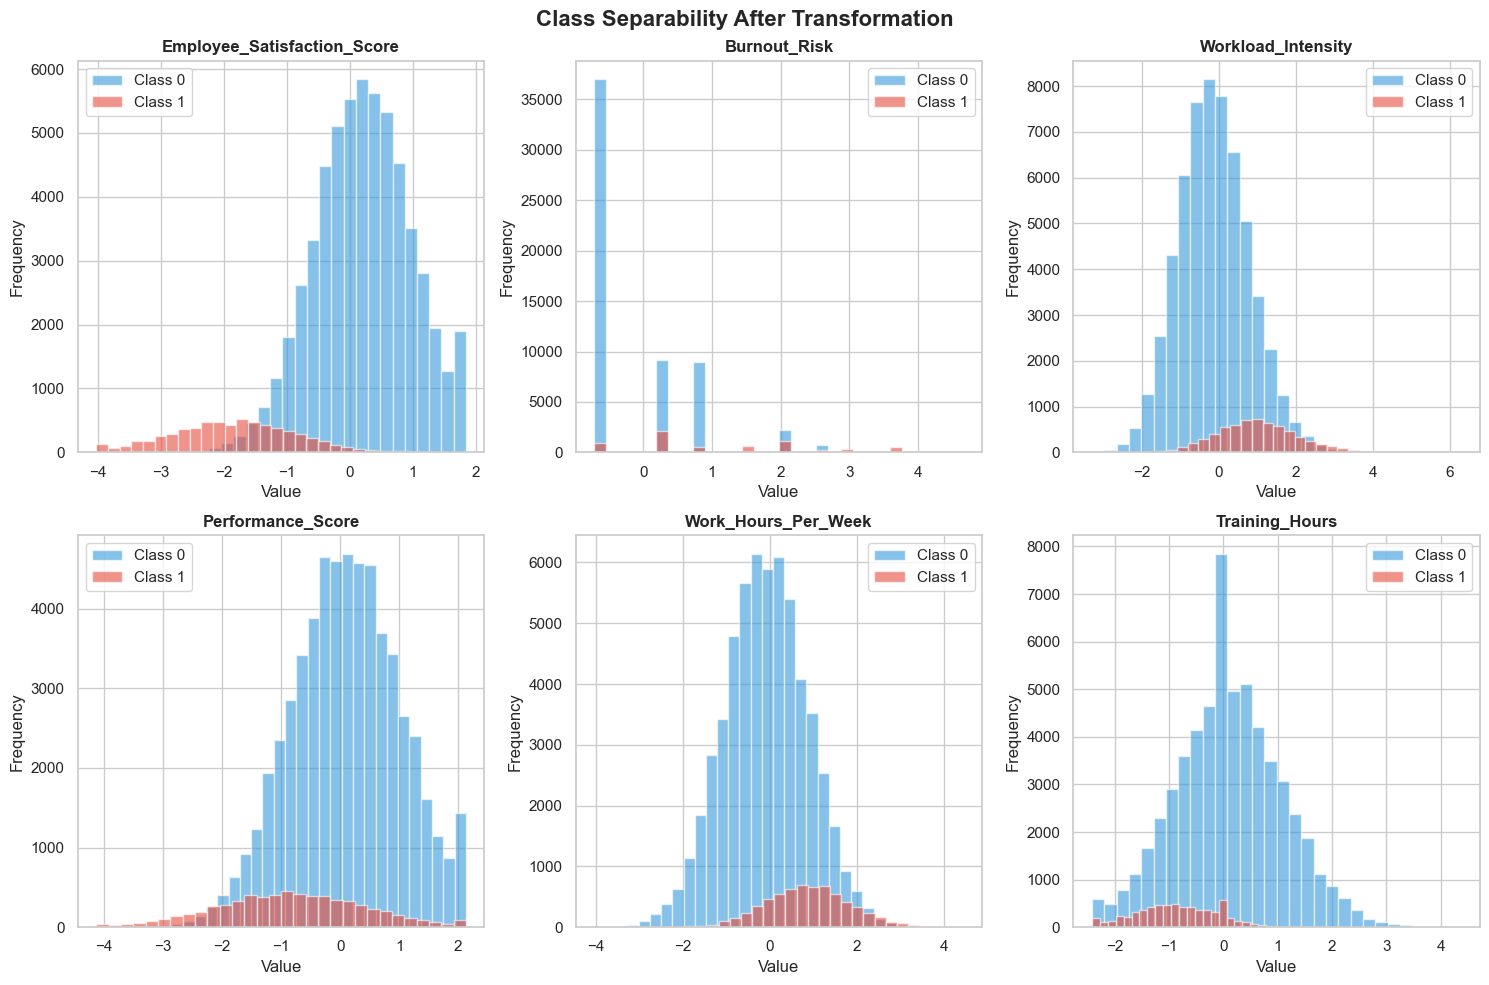

✓ Class separability visualization saved

VARIANCE ANALYSIS

Variance Comparison (Top 10):
                 Feature   Var_Before  Var_After        Ratio
          Overtime_Hours 3.477779e+01   1.000015 2.875443e-02
        Is_Underutilized 2.192058e-01   1.000015 4.561993e+00
       Performance_Score 4.083886e-01   1.000015 2.448686e+00
Tenure_Performance_Ratio 7.270477e-01   1.000015 1.375447e+00
            Project_Load 2.600310e-03   1.000015 3.845754e+02
          Monthly_Salary 1.133291e+07   1.000015 8.823991e-08
      Workload_Intensity 3.999411e-03   1.000015 2.500407e+02
          Overtime_Ratio 1.620103e-03   1.000015 6.172541e+02
        Projects_Handled 3.379791e+00   1.000015 2.958809e-01
          Training_Hours 6.285629e+01   1.000015 1.590955e-02

✓ All features have sufficient variance

POST-TRANSFORMATION SUMMARY REPORT

            Metric     Before      After Status
     Dataset Size 65000 rows 65000 rows      ✓
    Feature Count         21         21      ✓
   Miss

In [19]:
# Post-transformation EDA (train only)
results = post_transformation_eda.run_post_transformation_eda(
    df_before=df_train_sel,
    df_after=df_train_scaled,
    target='Resigned'
)


---
## Phase 7: Data Partition

**Objective:** Split data into training, validation, and test sets for machine learning.

**Key Activities:**
- Stratified split to maintain class distribution
- 65% Training, 15% Validation, 20% Test
- Generate partition quality report
- Save partitioned datasets

**Rationale:**
- Training: Model learning
- Validation: Hyperparameter tuning and model selection
- Test: Final unbiased performance evaluation
- Stratification ensures balanced class distribution across splits

2025-10-31 03:57:18,103 | INFO | ==== DATA PARTITION PIPELINE START ====
2025-10-31 03:57:18,106 | INFO | Starting data partitioning...
2025-10-31 03:57:18,332 | INFO | Data successfully partitioned: Train=116987, Val=26997, Test=35996


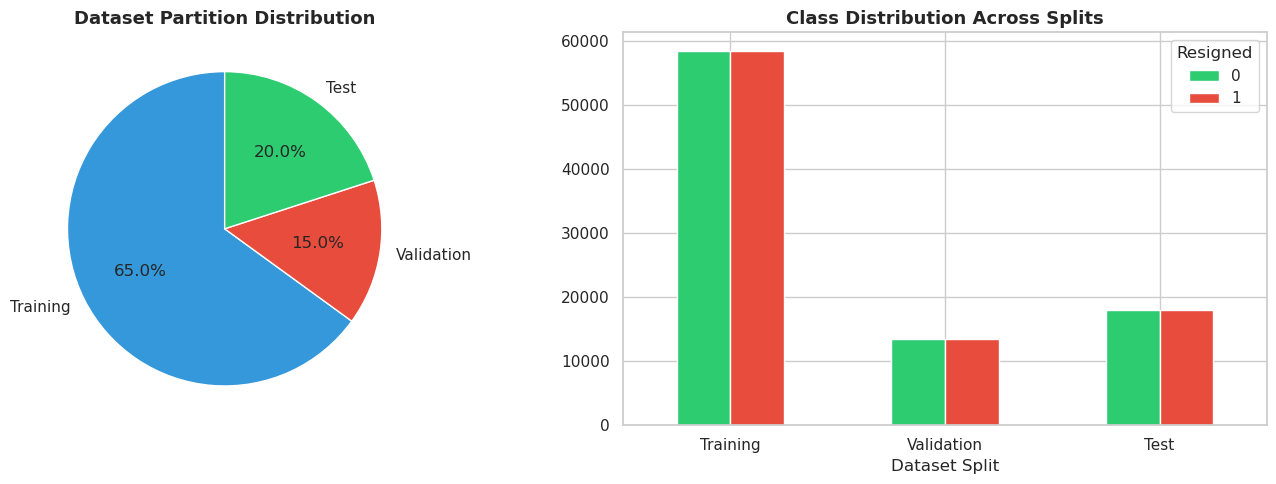

,Split,Samples,Class_0,Class_1,Attrition_Rate_%,Percentage
0,Training,116987,58493,58494,50.000000,65.000000
1,Validation,26997,13499,13498,50.000000,15.000000
2,Test,35996,17998,17998,50.000000,20.000000


2025-10-31 03:57:19,085 | INFO | Stratification check: max class-ratio diff = 0.00%
2025-10-31 03:57:26,955 | INFO | Saved train data → data/train_data.csv ((116987, 46))
2025-10-31 03:57:28,741 | INFO | Saved val data → data/val_data.csv ((26997, 46))
2025-10-31 03:57:31,133 | INFO | Saved test data → data/test_data.csv ((35996, 46))
2025-10-31 03:57:31,137 | INFO | Partition metadata saved as 'partition_metadata.json'.
2025-10-31 03:57:31,138 | INFO | ==== DATA PARTITION PIPELINE COMPLETE ====


In [33]:
# Partitioning moved earlier; see split-first pipeline cell.


---
## FYP Iteration 1: END